# Building A U-Net, One Step at a Time

Rise and shine! It's time for deep learning.

![title](u-net-architecture.png)

In today's tutorial, and subsequent classes, we will be building our own deep neural network architecture and putting it to work on a practical problem. Specifically, we will be creating the popular U-Net architecture, which revolutionized many images segmentation tasks. We will be tackling the problem of brain tumor segmentation based off of 2D slices of images. Many if not all of the methods we show in this tutorial can be applied on 3D images, but 2D images are slightly less complex and take less computing power.

There are a few intermediate goals we will hit in this tutorial. They are:

- Preprocessing 3D MRI data into a collection of intensity normalized, uniformly-sized 2D slices, and splitting them into class-balanced training and testing datasets for training our neural networks.
- Constructing the first arm of the U-Net, "the downsampling arm", and training it as an image classifier (in our case, contains-tumor or does-not-contain-tumor). This will introduce the basics of home-brewed neural networks without adding some of the more complicated bits that characterize the full U-Net architecture.
- Showing how we can generate class-activation maps for our downsampling arm. These maps will show us which parts of an image were most informative in the tumor-no-tumor classification task. We will then use these activation maps as an additional channel during training of the full U-Net
- Building the upsampling arm of the U-Net and adding concatenation layers. We will train this new network to segment brain tumors, instead of merely identifying if they are present.

Without further ado, let's get started on the data preprocessing.

## Preprocessing the Data

We will be using the famed BraTS dataset during this tutorial. The BraTS dataset is a collection of scans from a cohort of patients with low-grade and high-grade glioblastoma tumors. For each patient, one visit is presented, with four MRI sequences: T2, pre-contrast T1, post-contrast T1, and FLAIR. Annotations of enhancing tumor, edema, and necrosis are provided for each patient visit, and are generated from the average of multiple radiologists' hand-drawn annotations.

![title](BRATS.png)

Although much medical data comes in DICOM format, we will be providing the data to you in NIFTI format for this tutorial. In order to load and manipulate NIFTI data, we will need the python package "nibabel". Take a moment, if you haven't already, to install nibabel via the pip package installer. This installer should come with most installations of Python.

The first step for us is to load a Nifti image, and try and get a sense of the sort of data we're dealing with.

In [1]:
import nibabel as nib  # By convention, nibabel is abbreviated to nib, much as numpy is abbreviated to np

input_file = 'Brats17_2013_18_1_flair.nii.gz'

loaded_nifti = nib.load(input_file)

C:\Users\James\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Easy enough! Let's see what we're dealing with here.

In [2]:
print(loaded_nifti)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (240, 240, 155)
affine: 
[[ -1.   0.   0.  -0.]
 [  0.  -1.   0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b   

Weird. You may have thought you were loading the MRI data into a data array, but instead you were loading data into a nibabel Nifti object. This object contains the data of the MRI scan in numpy format, but also contains extra information about the image stored in the NIFTI file's header. This is what you see printed above. This information can tell you about the resolution of an image (pixdim), the orientation of the patient with respect to the scanner (affine), and other information that may be useful to a medical imaging program (e.g. data-type).

When it comes to deep learning in this tutorial, however, we're mostly interested numpy array data that represents this scan. We need a new command to get that data.

In [3]:
scan_array = loaded_nifti.get_data()
print(type(scan_array))
print(scan_array.shape)

<class 'numpy.ndarray'>
(240, 240, 155)


Much better -- a numpy array with 512 rows, 512 columns, and 20 axial slices. It's usually a profitable first step to visualize your data, and that's what we're going to try to do now. Let's load up matplotlib and see if we can't take a look.

TypeError: Invalid dimensions for image data

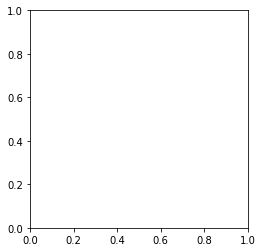

In [4]:
# Just for Jupyter Notebooks
%matplotlib inline

import matplotlib.pyplot as plt

im = plt.imshow(scan_array, interpolation='none', origin='lower', cmap='gray')
plt.show()

Oh -- duh, you can't show a 3D image the same way that you would show a 2D image. Using some of numpy's array slicing features, however, we can look at individual slices in our volume.

(240, 240, 155)
0


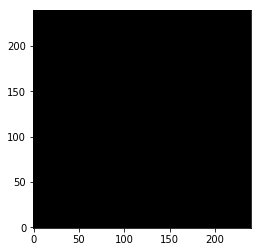

1


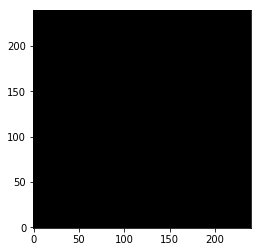

2


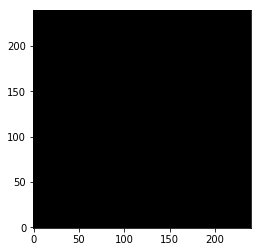

3


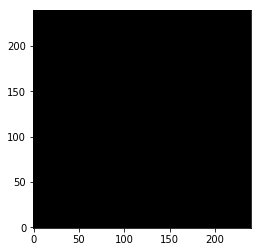

4


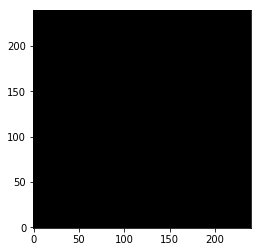

5


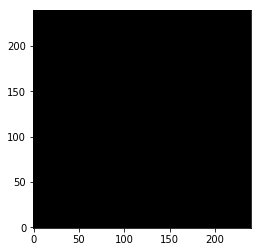

6


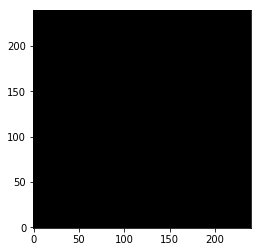

7


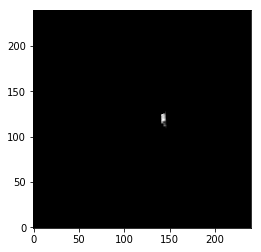

8


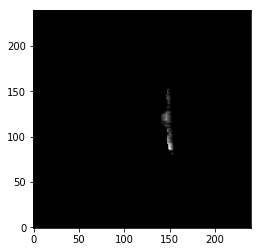

9


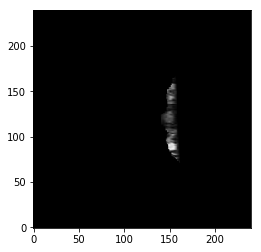

10


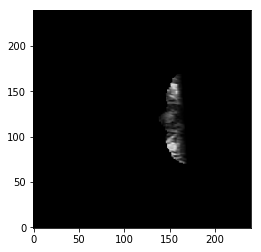

11


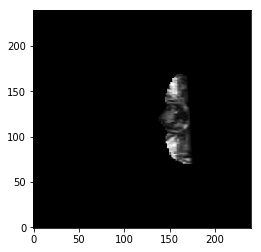

12


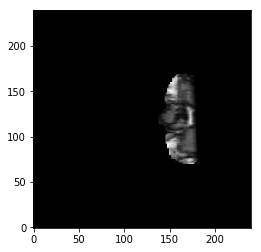

13


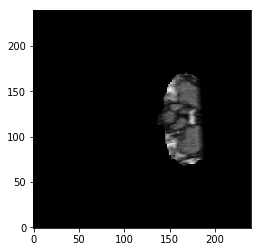

14


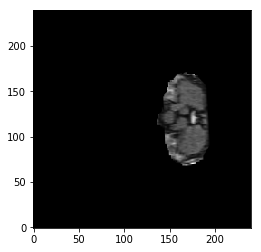

15


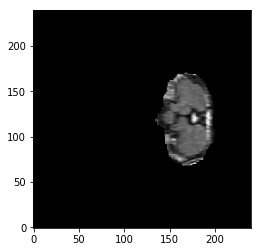

16


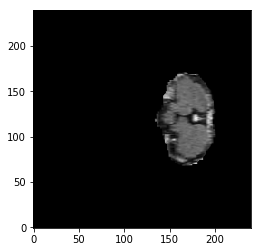

17


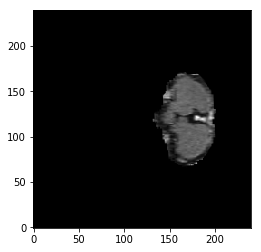

18


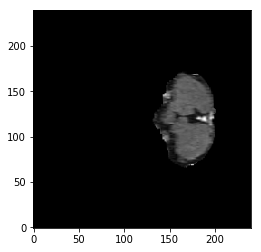

19


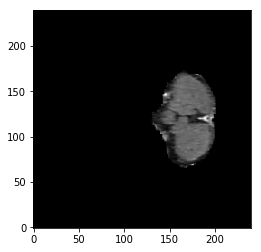

20


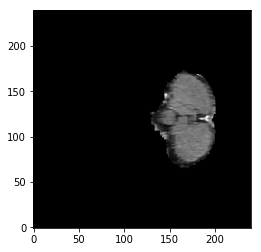

21


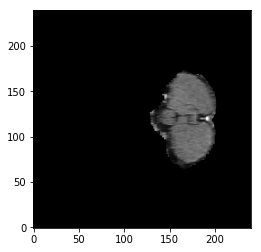

22


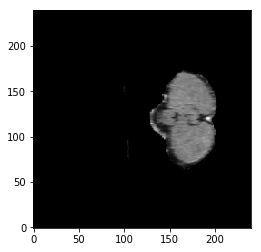

23


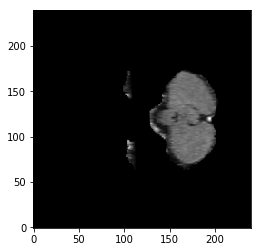

24


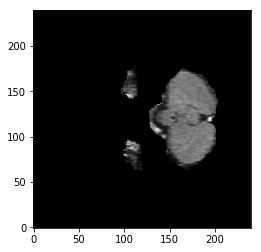

25


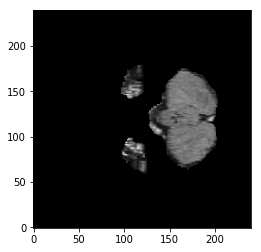

26


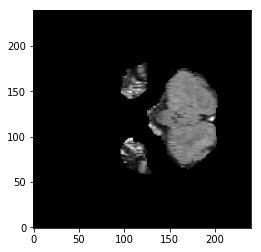

27


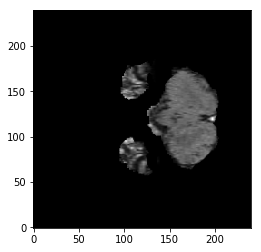

28


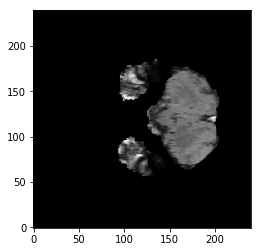

29


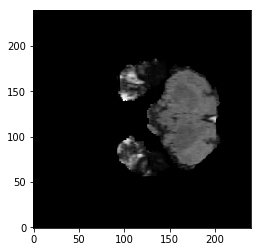

30


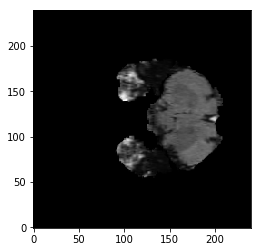

31


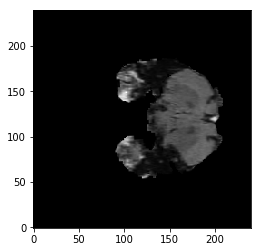

32


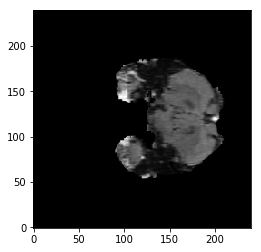

33


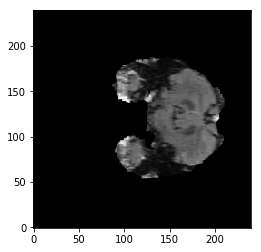

34


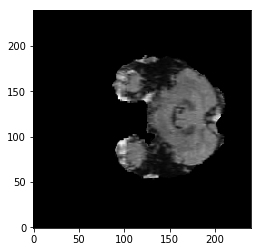

35


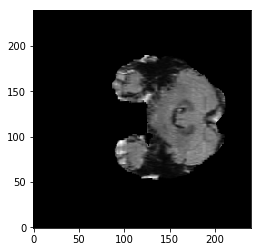

36


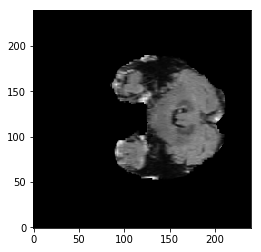

37


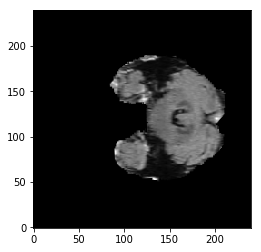

38


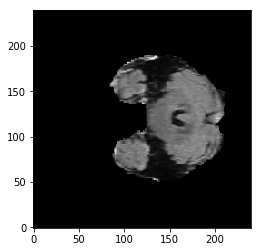

39


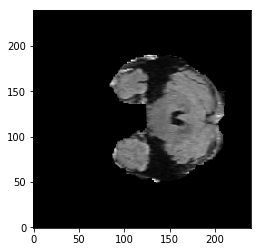

40


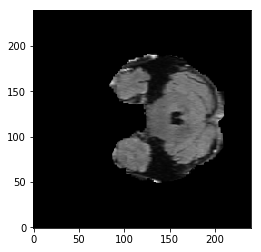

41


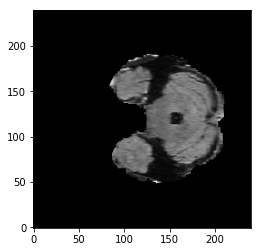

42


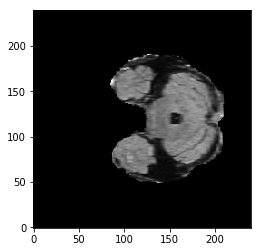

43


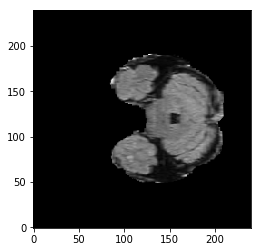

44


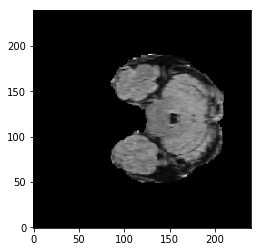

45


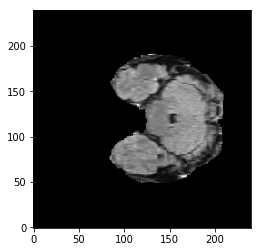

46


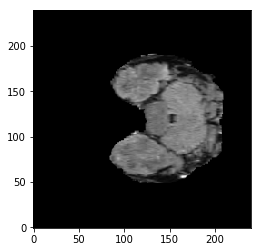

47


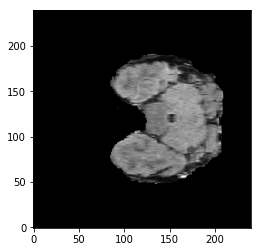

48


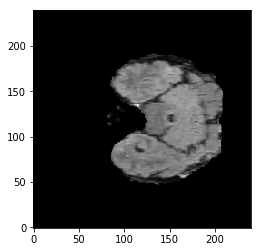

49


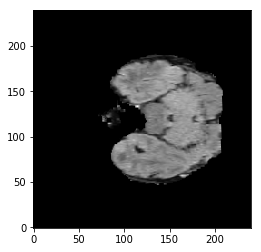

50


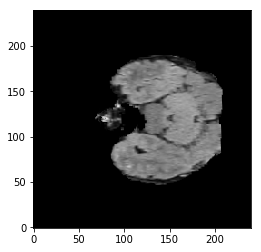

51


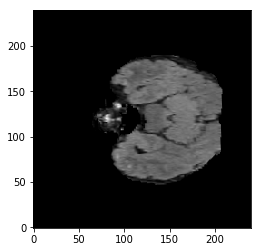

52


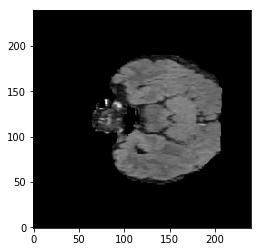

53


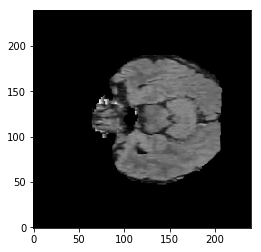

54


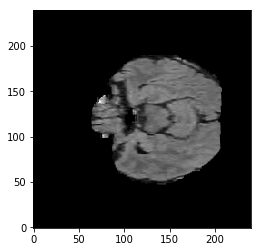

55


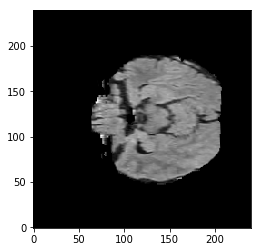

56


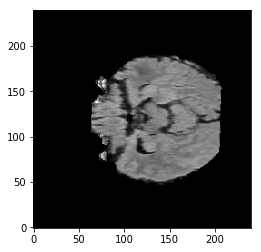

57


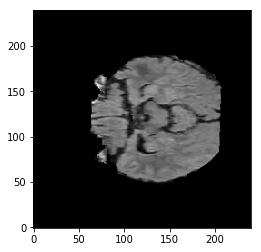

58


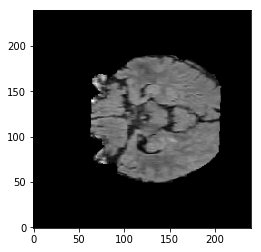

59


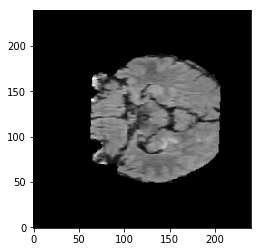

60


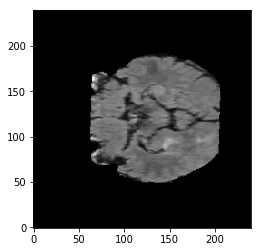

61


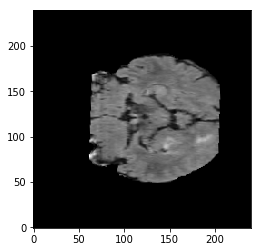

62


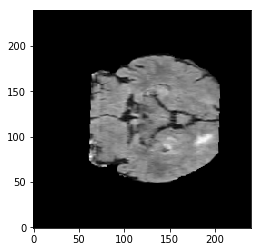

63


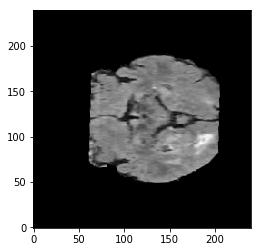

64


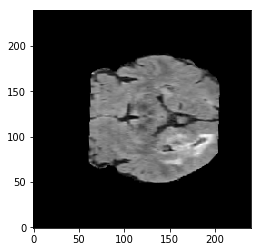

65


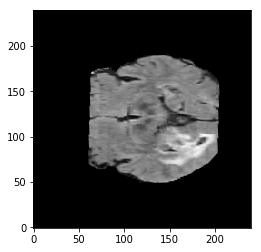

66


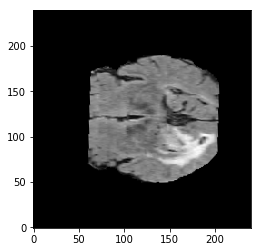

67


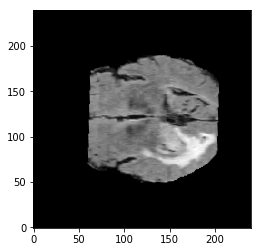

68


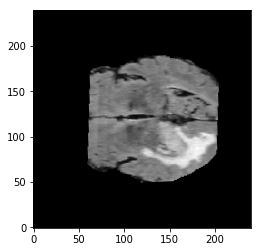

69


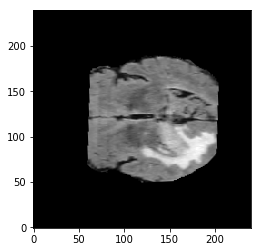

70


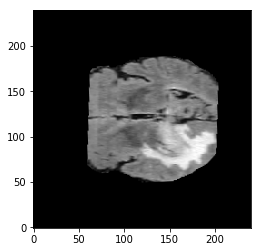

71


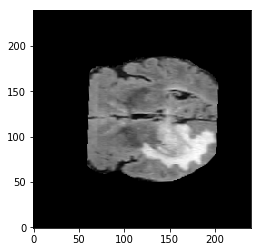

72


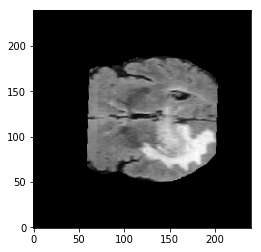

73


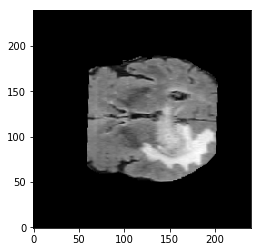

74


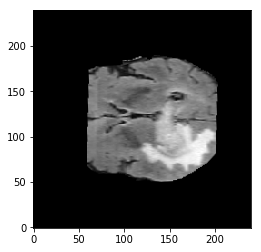

75


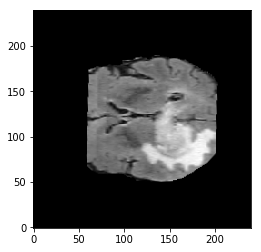

76


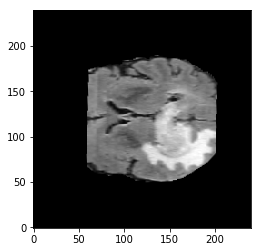

77


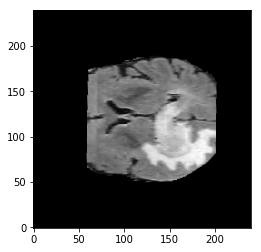

78


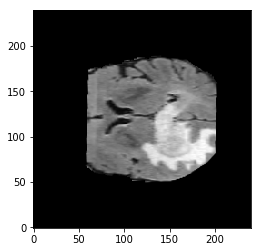

79


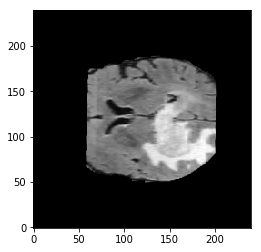

80


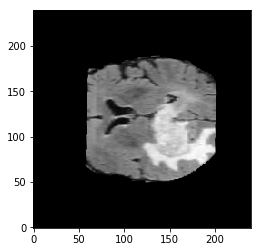

81


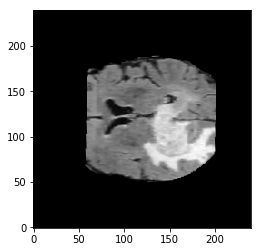

82


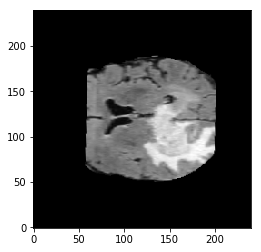

83


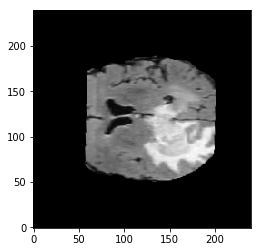

84


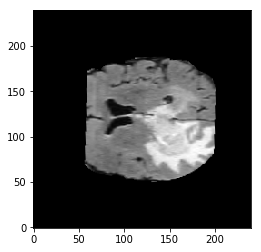

85


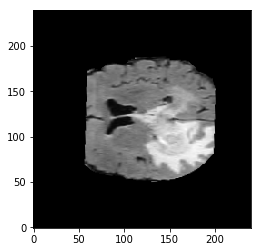

86


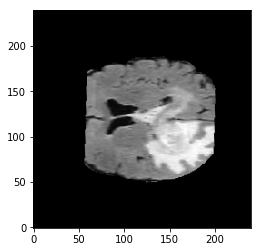

87


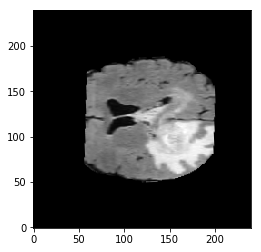

88


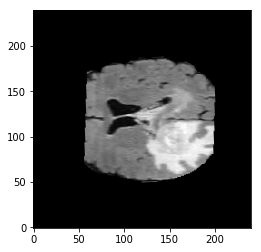

89


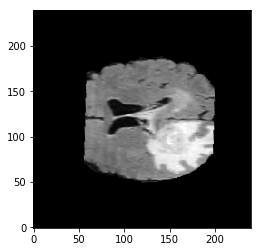

90


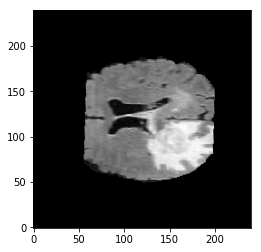

91


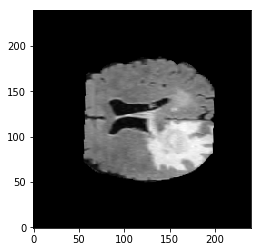

92


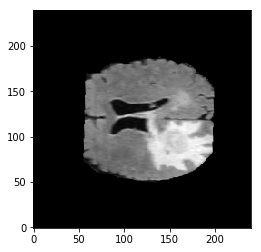

93


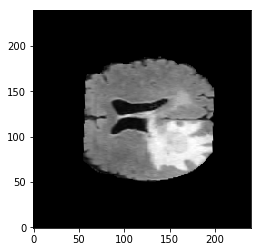

94


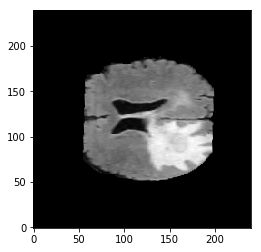

95


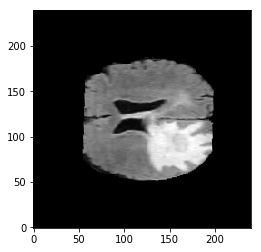

96


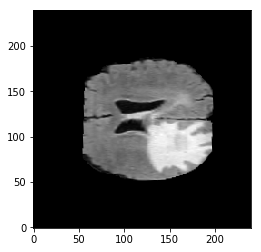

97


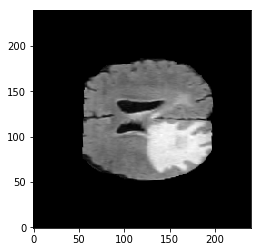

98


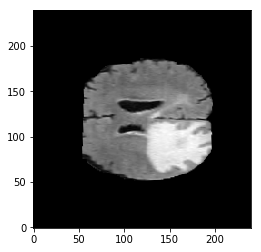

99


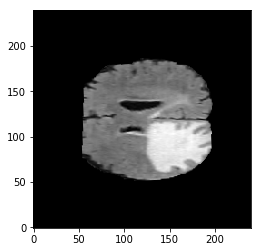

100


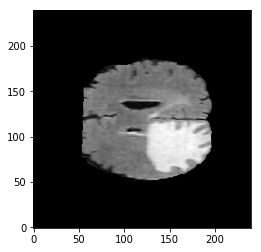

101


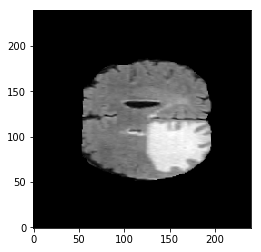

102


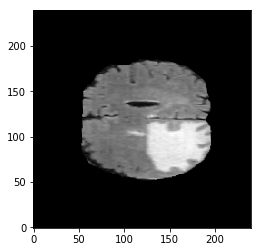

103


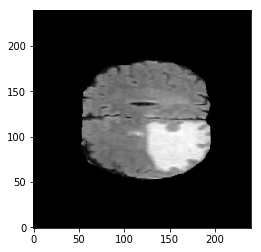

104


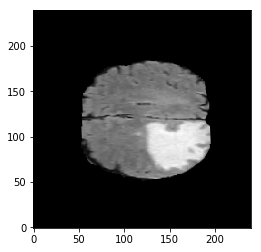

105


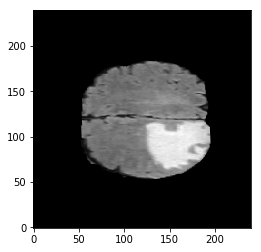

106


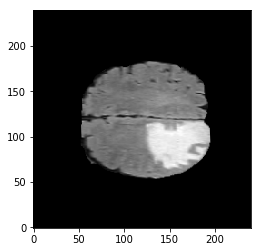

107


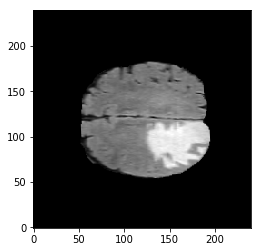

108


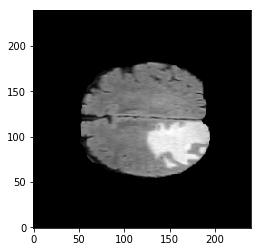

109


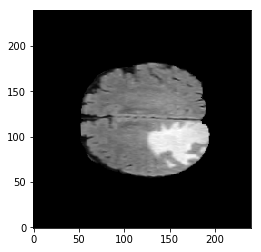

110


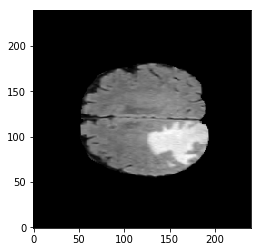

111


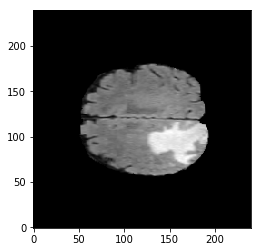

112


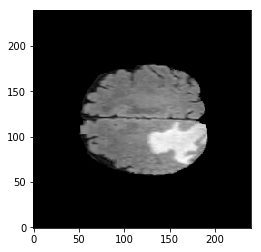

113


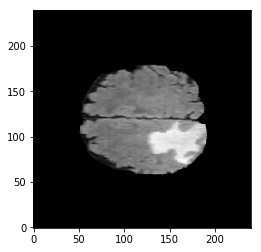

114


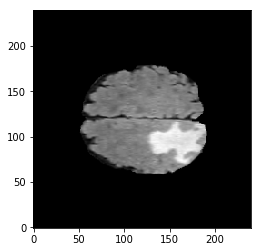

115


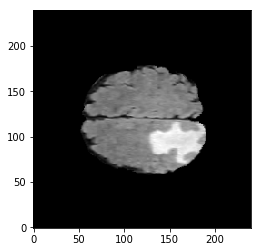

116


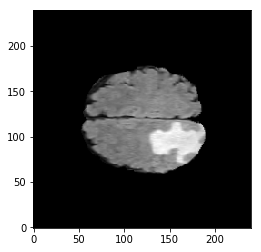

117


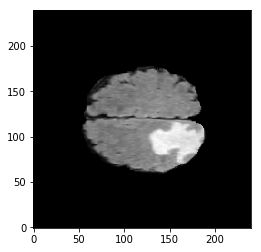

118


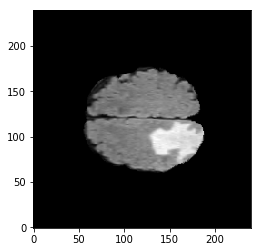

119


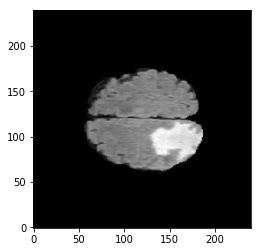

120


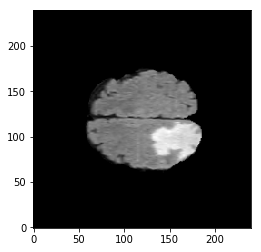

121


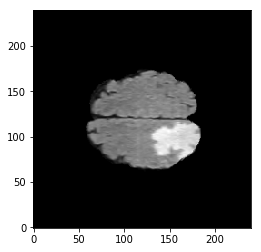

122


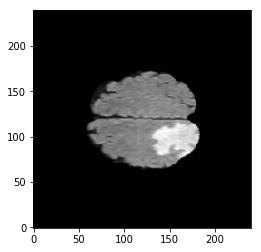

123


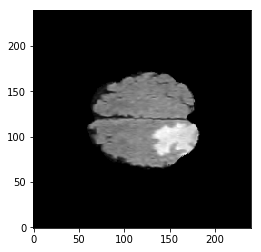

124


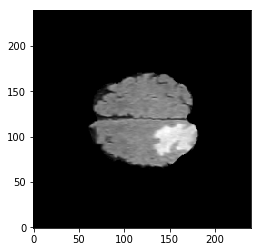

125


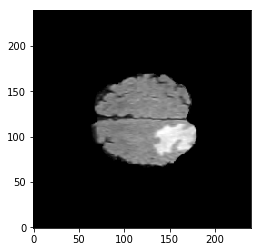

126


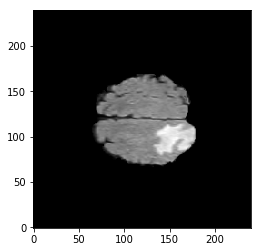

127


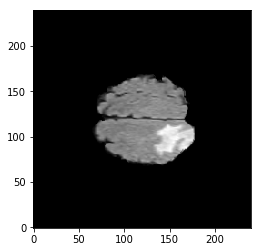

128


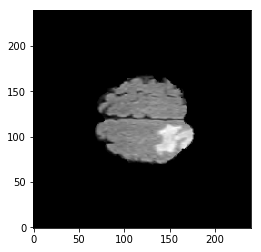

129


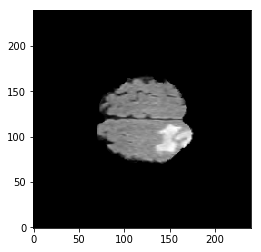

130


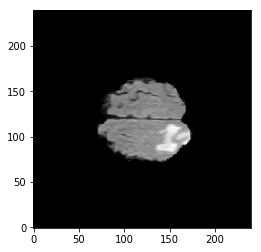

131


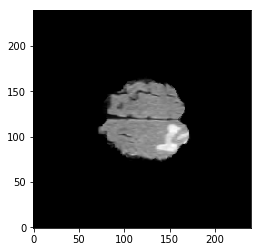

132


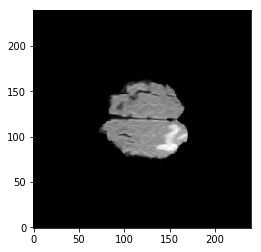

133


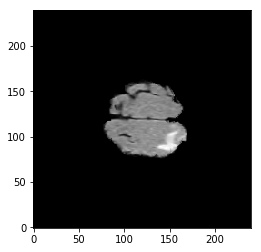

134


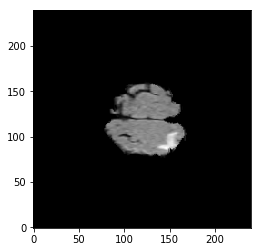

135


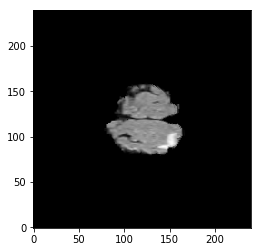

136


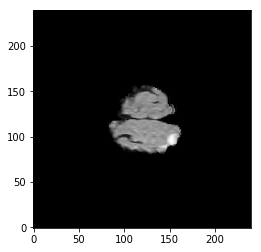

137


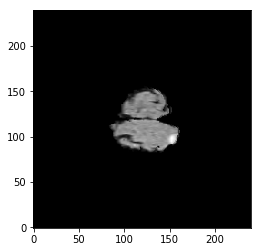

138


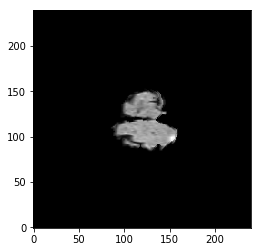

139


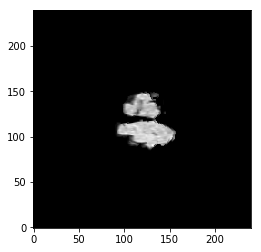

140


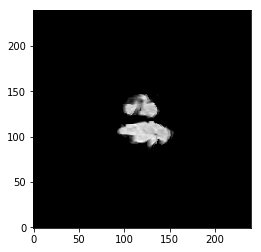

141


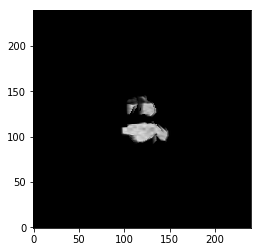

142


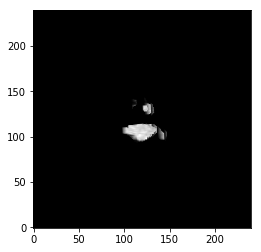

143


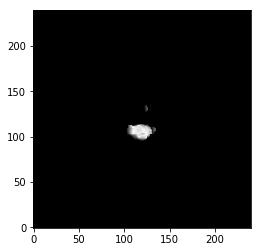

144


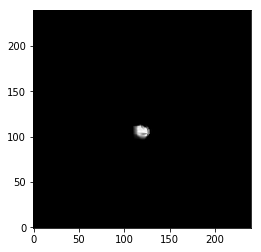

145


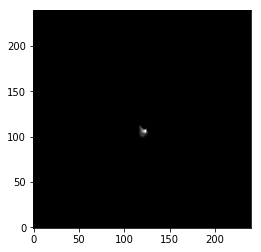

146


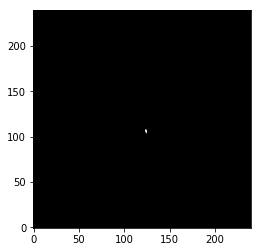

147


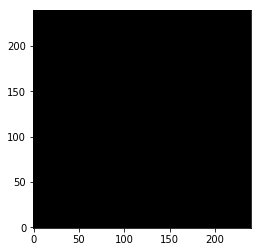

148


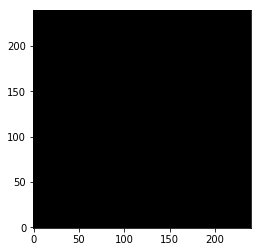

149


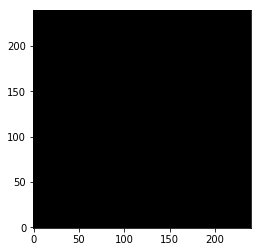

150


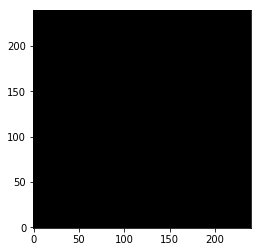

151


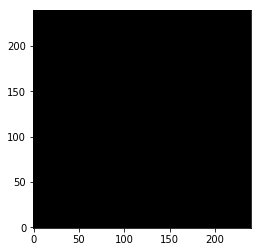

152


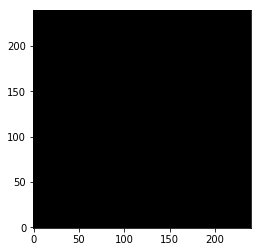

153


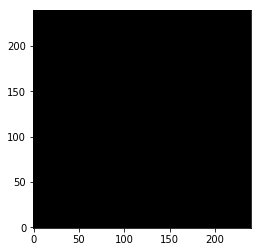

154


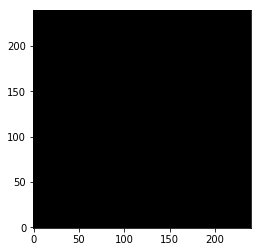

In [7]:
print(scan_array.shape)
total_axial_slices = scan_array.shape[2]

for axial_slice_num in range(total_axial_slices):
    
    print(axial_slice_num)
    im = plt.imshow(scan_array[:, :, axial_slice_num], interpolation='none', origin='lower', cmap='gray')
    plt.show()

That's more like it! Slices from a MRI of a patient with a brain tumor. You'll notice that the brain is not facing the traditional direction when we load in matplotlib. This is because we threw away the patient orientation data with the rest of the NIFTI header, and loaded our array without further transformation. Without knowing how to orient the data, numpy simply displays it as is. For our sanity, let's rotate it the correct direction.

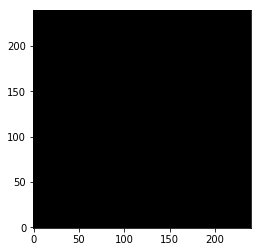

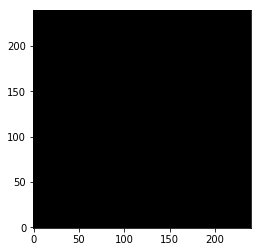

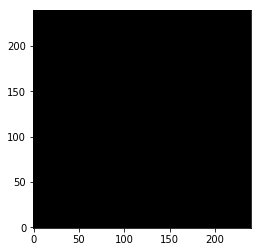

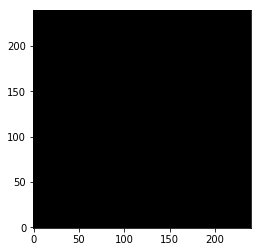

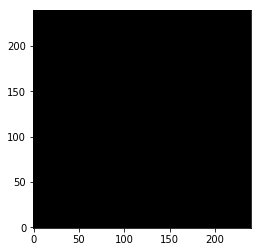

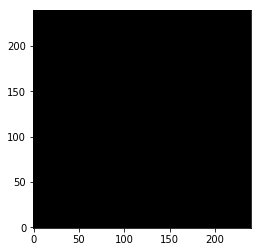

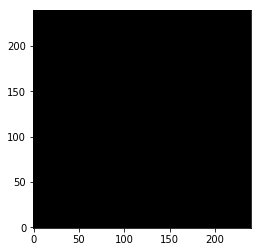

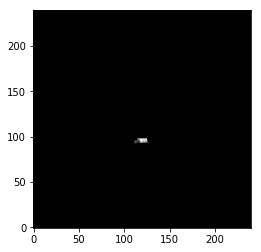

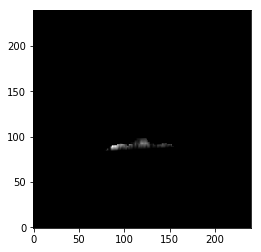

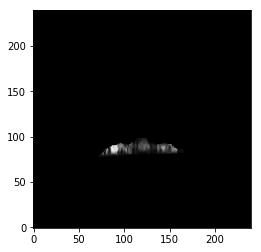

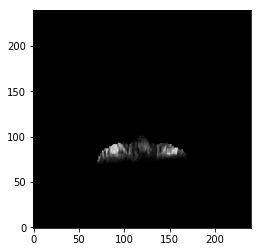

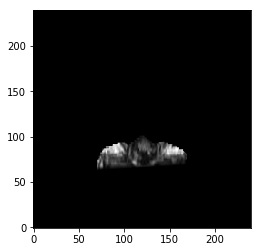

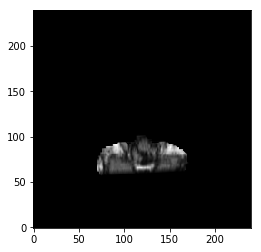

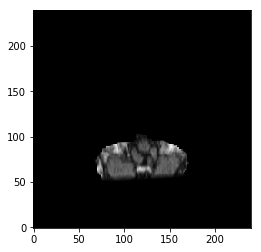

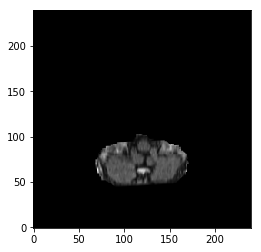

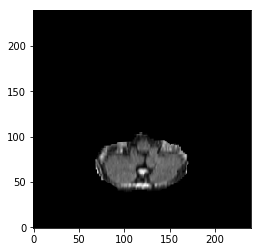

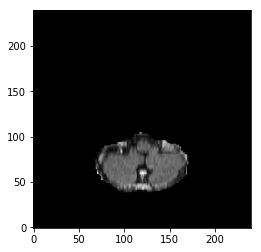

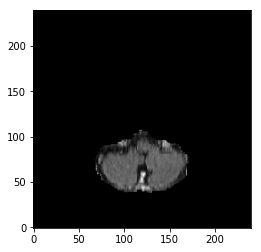

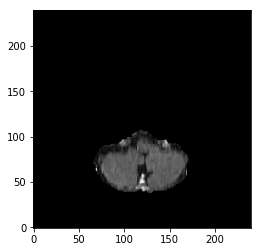

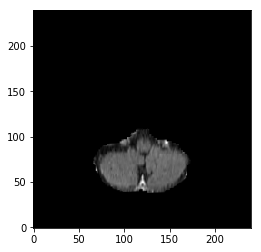

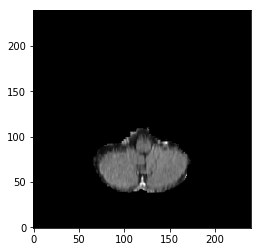

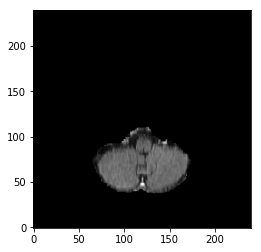

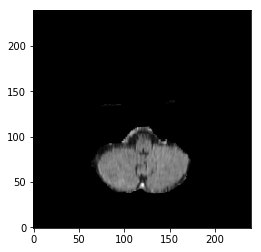

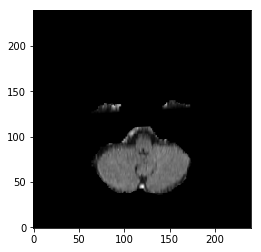

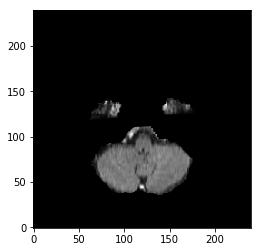

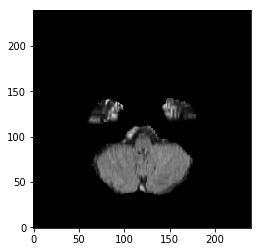

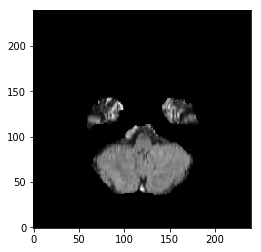

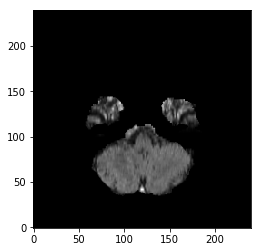

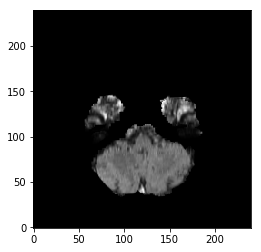

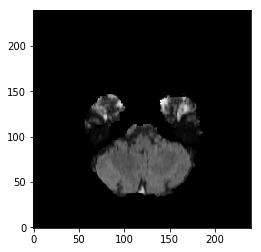

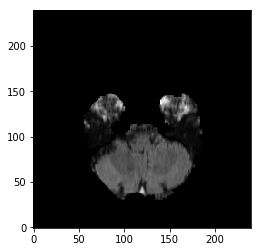

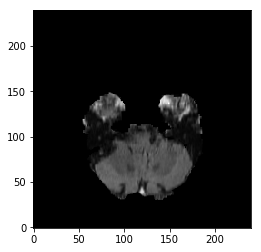

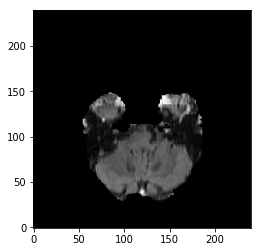

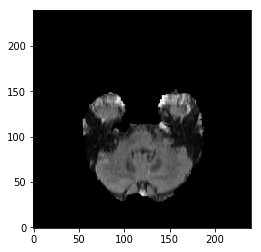

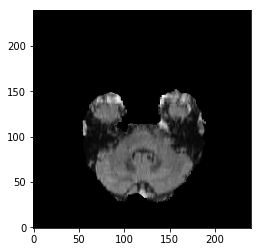

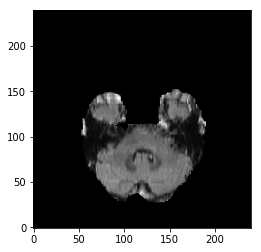

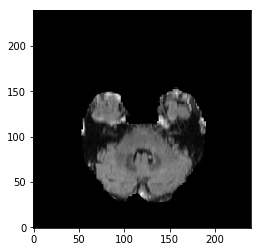

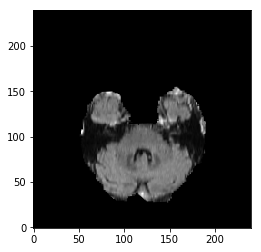

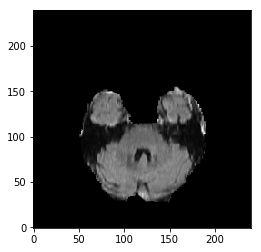

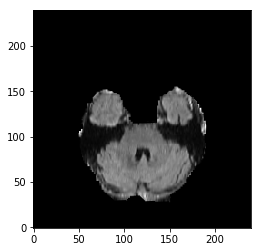

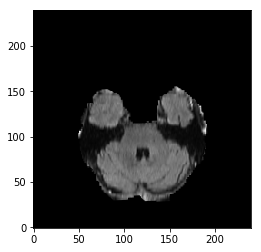

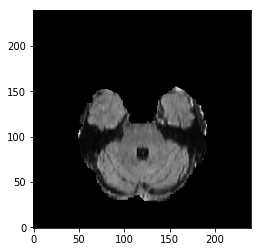

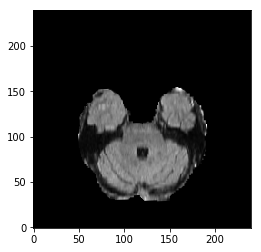

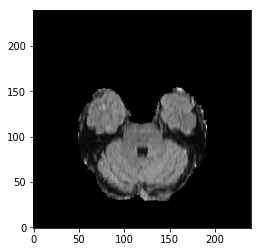

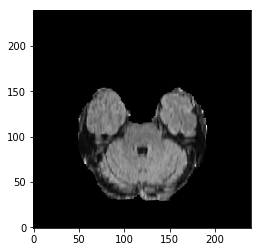

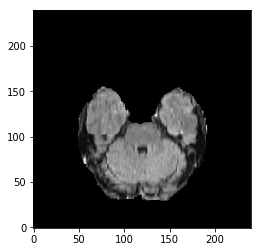

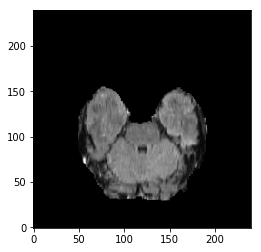

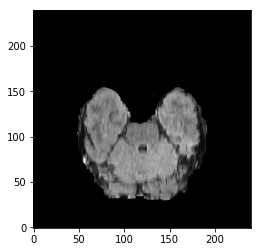

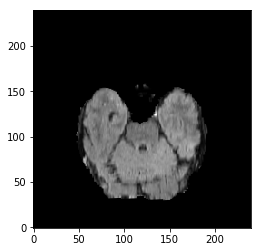

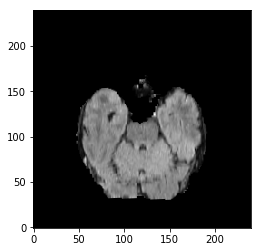

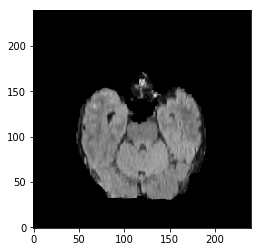

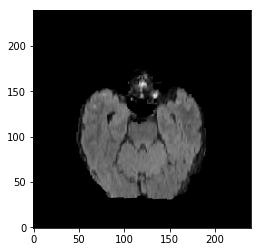

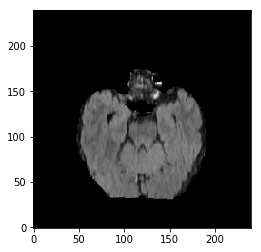

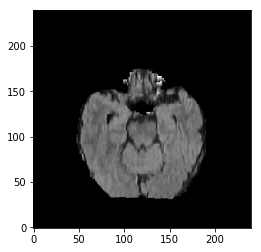

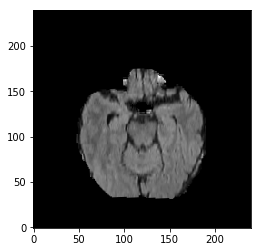

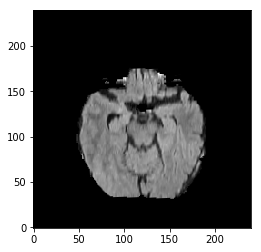

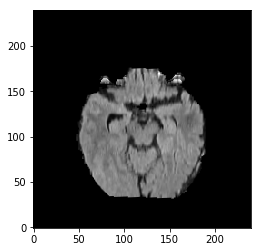

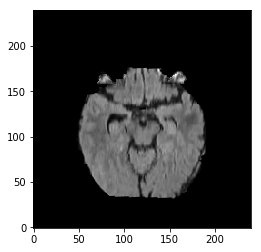

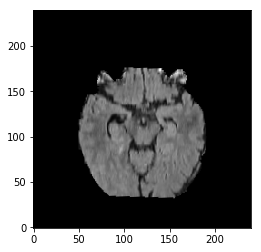

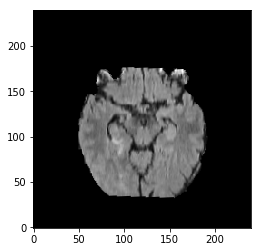

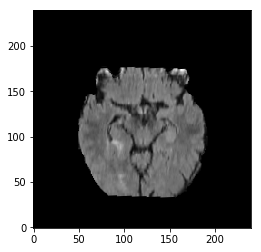

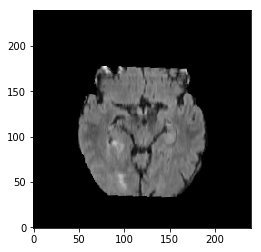

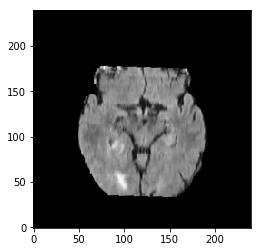

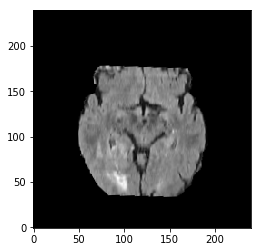

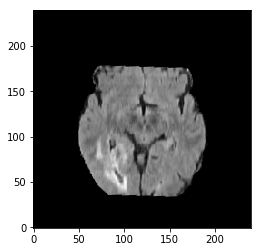

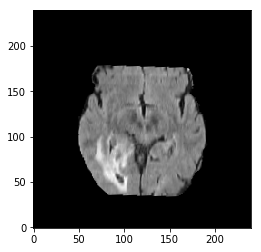

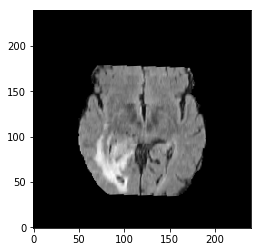

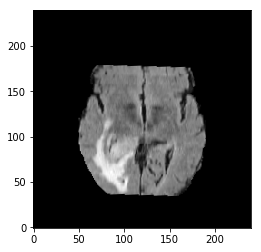

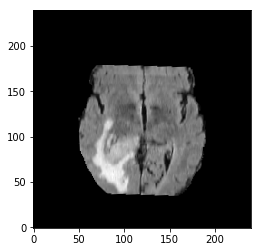

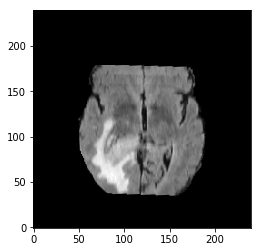

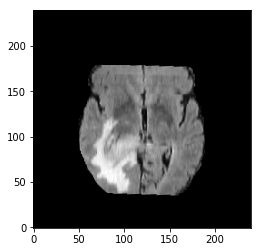

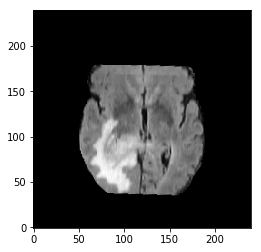

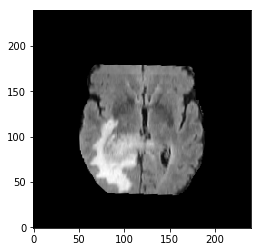

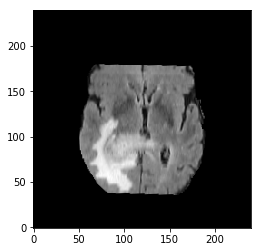

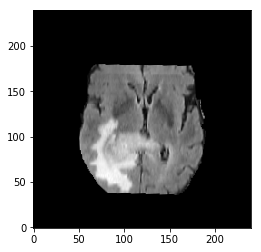

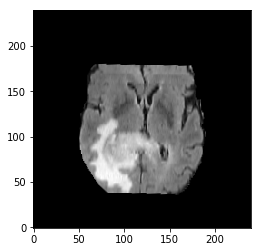

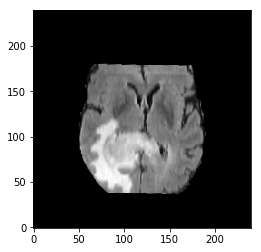

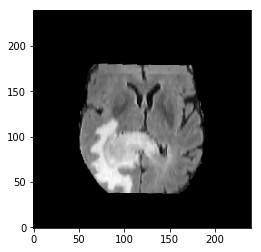

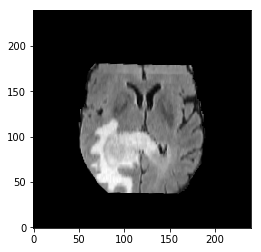

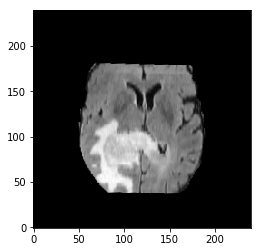

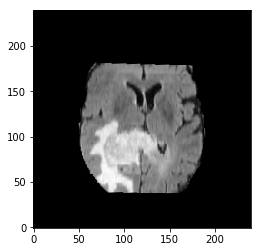

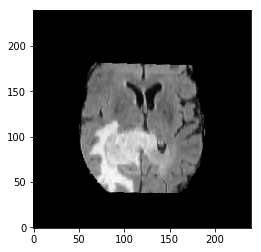

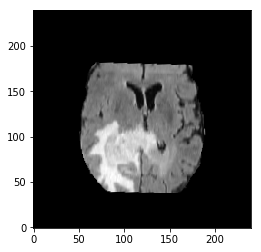

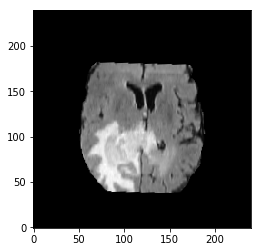

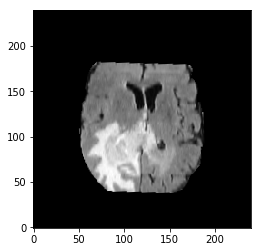

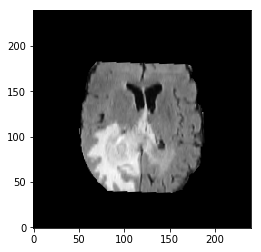

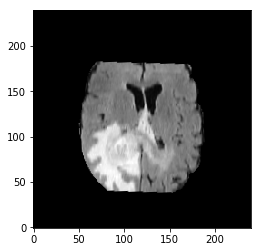

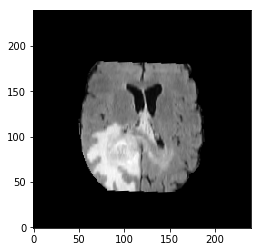

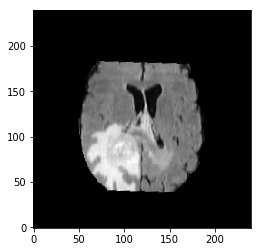

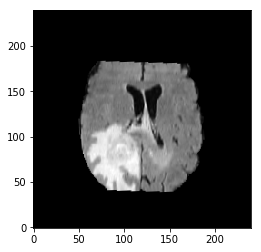

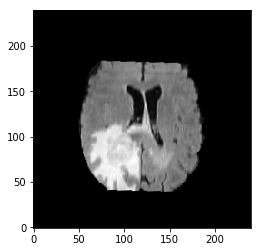

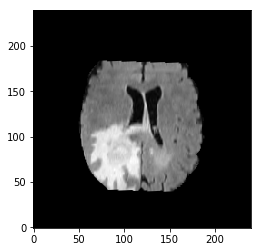

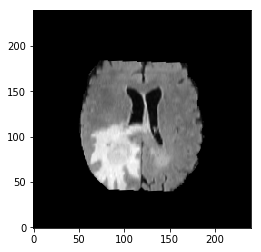

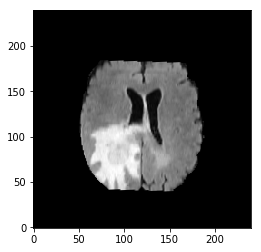

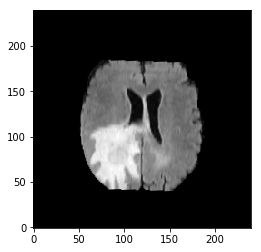

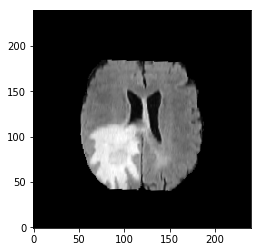

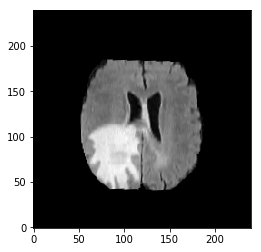

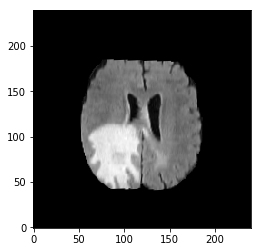

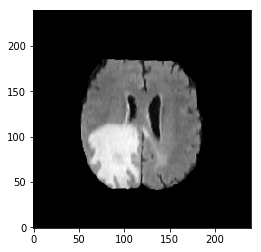

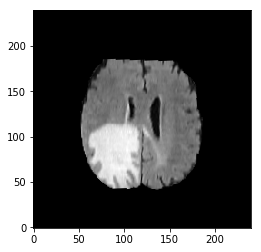

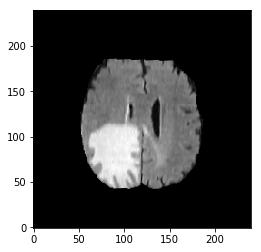

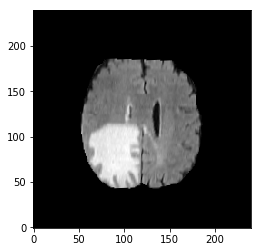

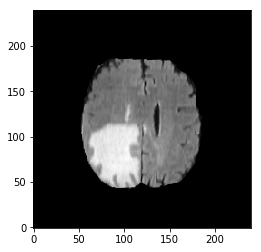

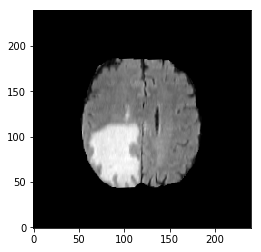

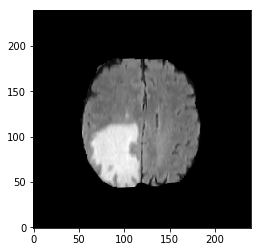

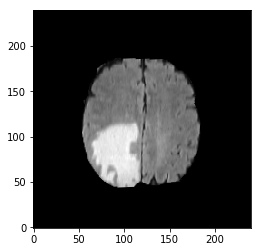

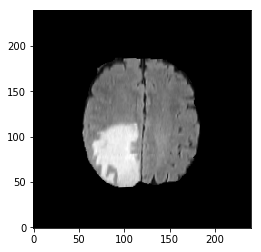

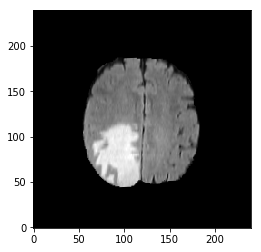

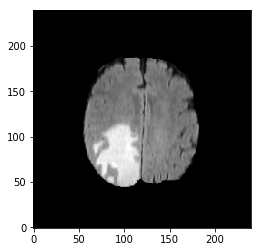

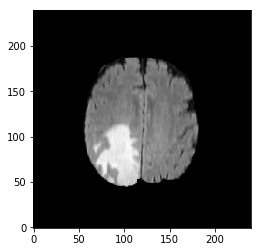

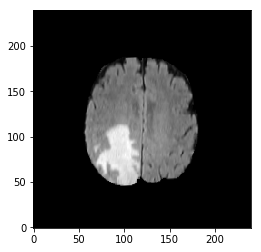

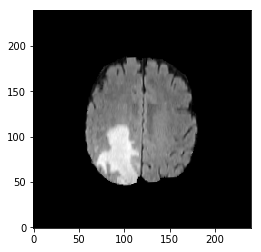

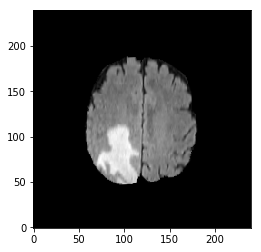

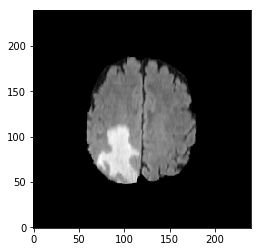

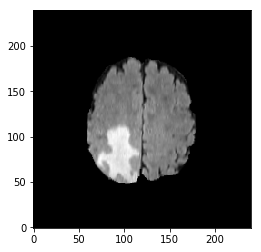

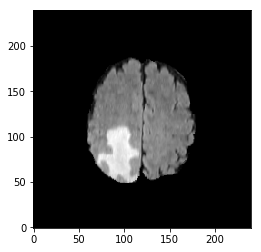

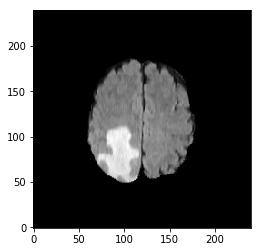

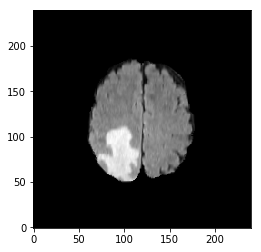

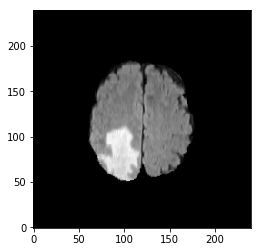

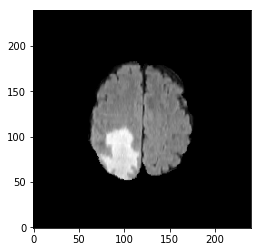

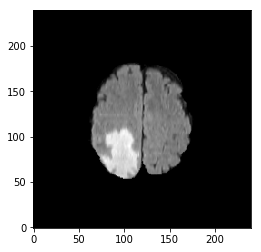

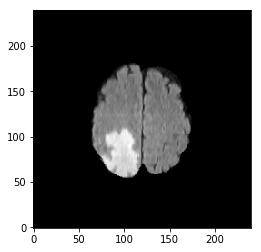

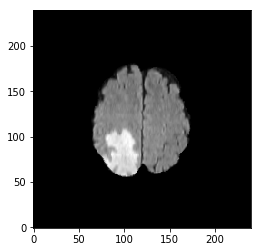

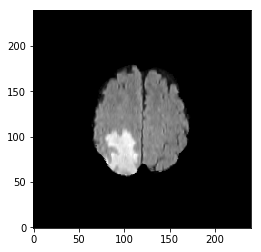

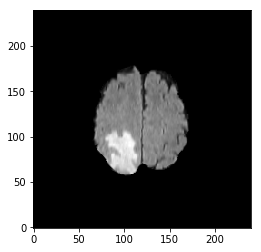

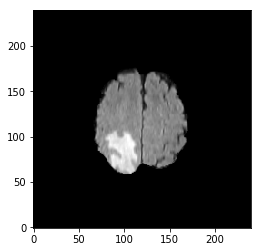

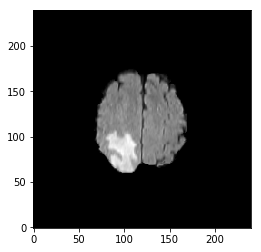

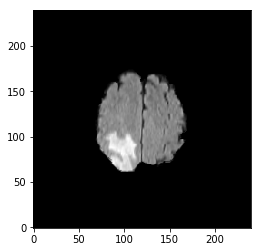

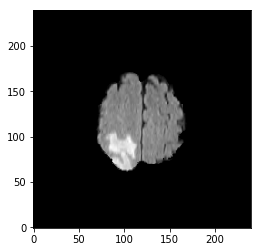

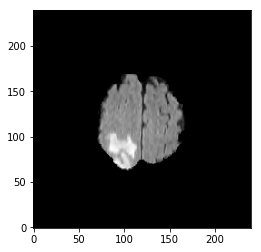

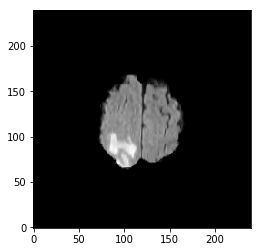

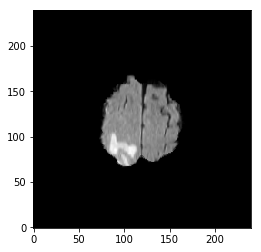

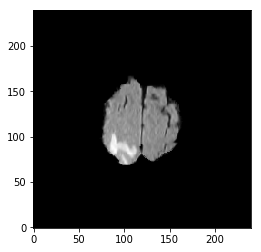

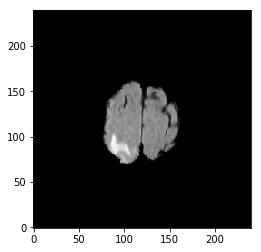

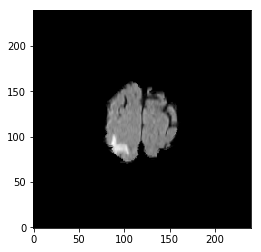

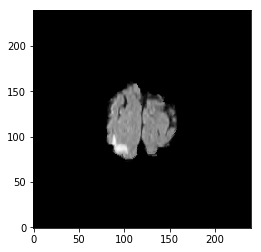

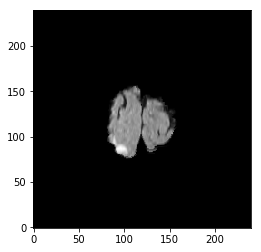

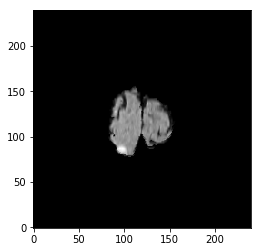

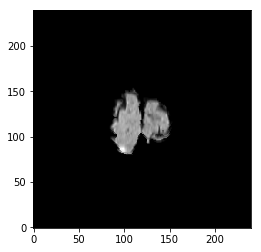

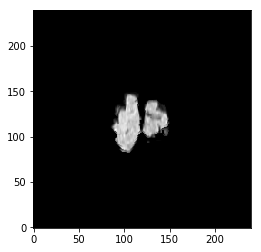

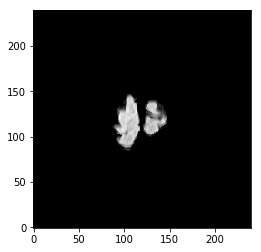

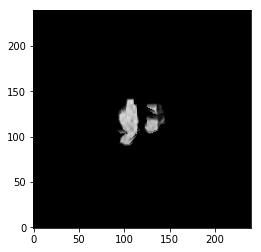

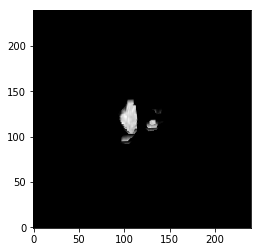

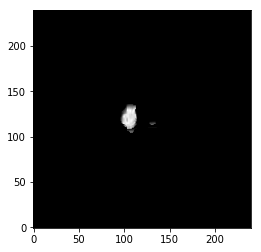

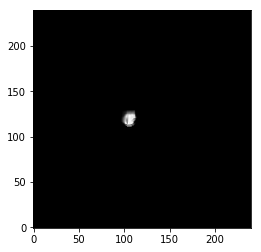

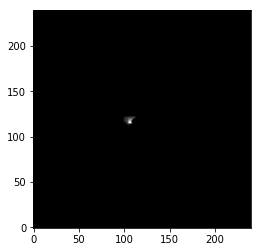

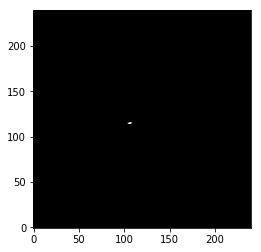

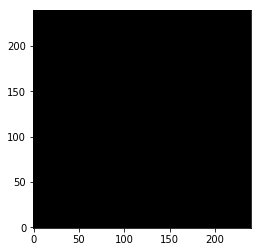

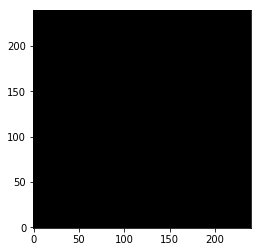

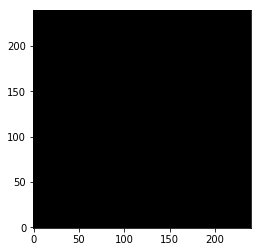

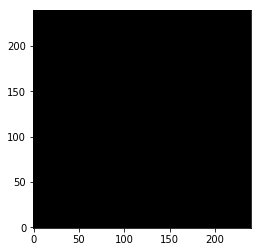

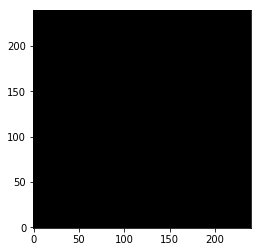

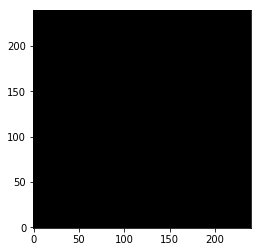

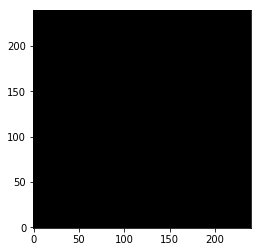

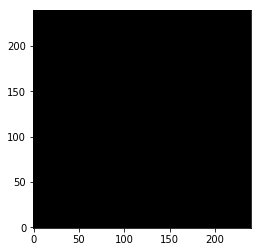

In [9]:
import numpy as np

total_axial_slices = scan_array.shape[2]

for axial_slice_num in range(total_axial_slices):
    
    # Using numpy, we rotate 90 degrees clockwise 3 times, making the nose point "up"
    im = plt.imshow(np.rot90(scan_array[:, :, axial_slice_num], 1), interpolation='none', origin='lower', cmap='gray')
    plt.show()

Much better, although it's anyone's guess at this point which direction is right and which direction is left. Let's get the tumor label provided by the clinicians and load that up side-by-side.

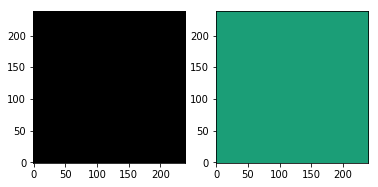

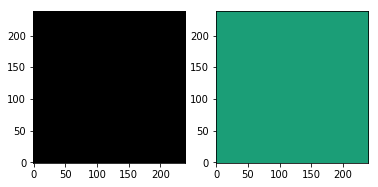

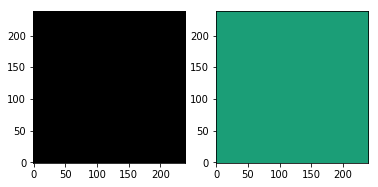

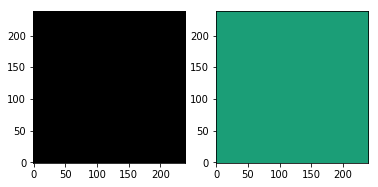

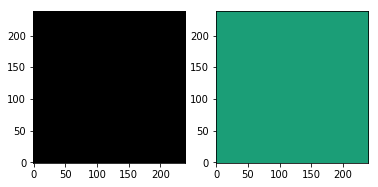

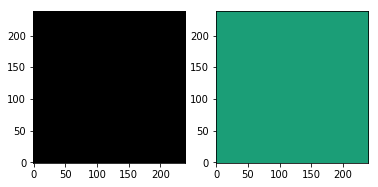

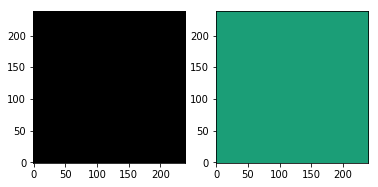

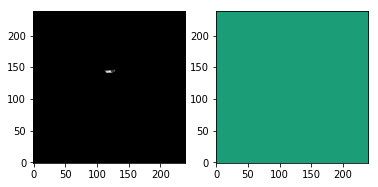

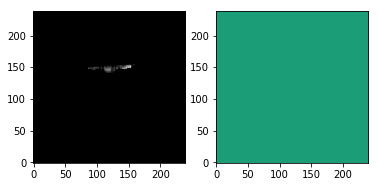

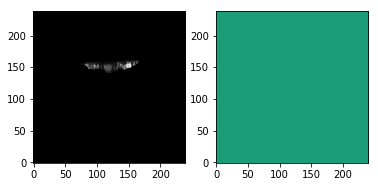

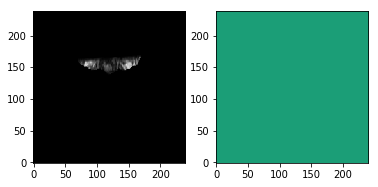

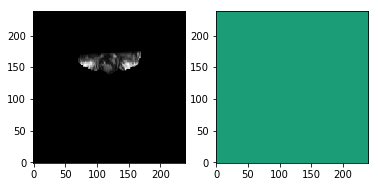

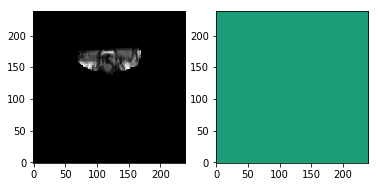

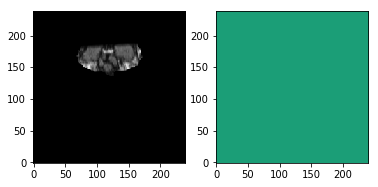

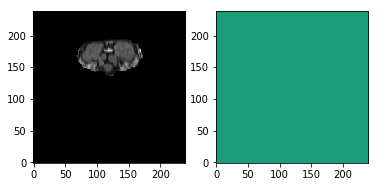

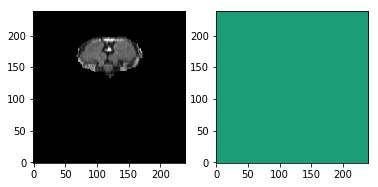

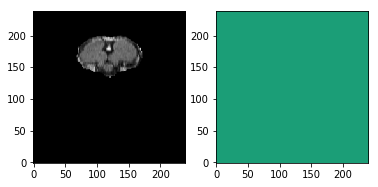

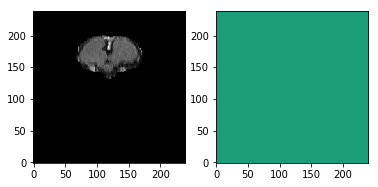

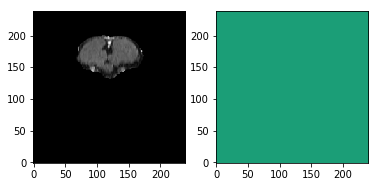

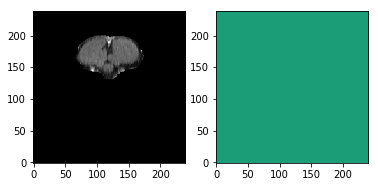

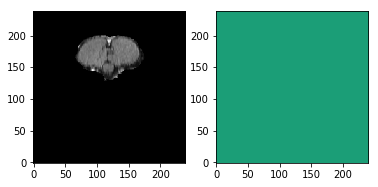

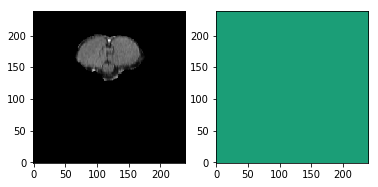

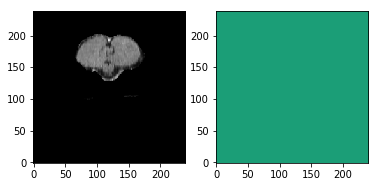

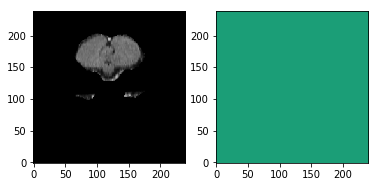

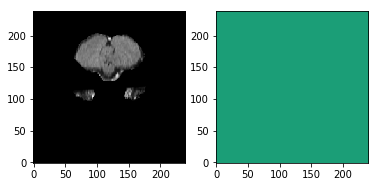

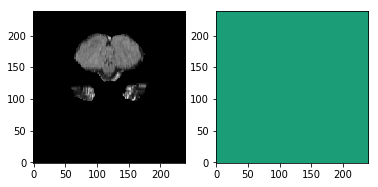

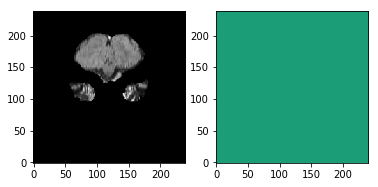

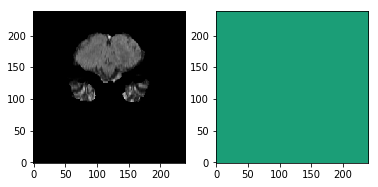

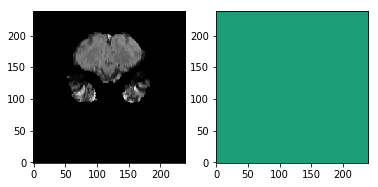

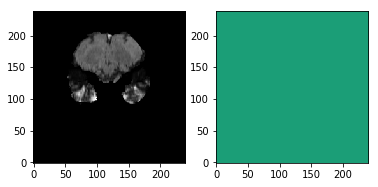

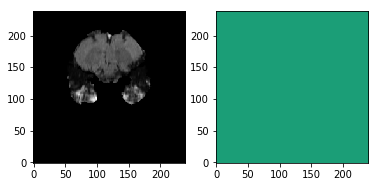

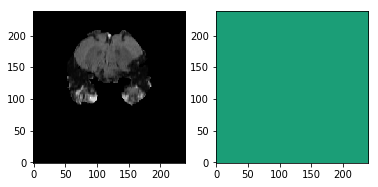

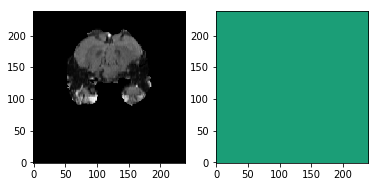

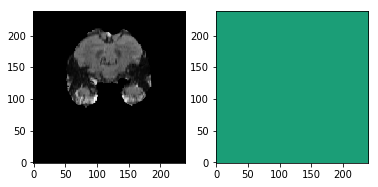

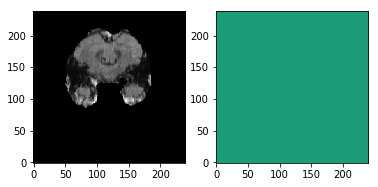

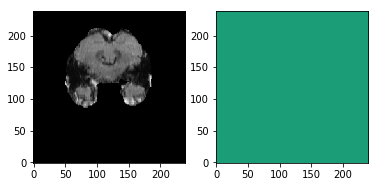

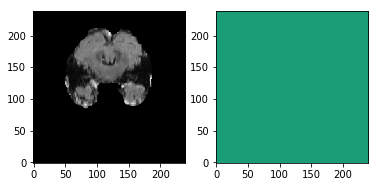

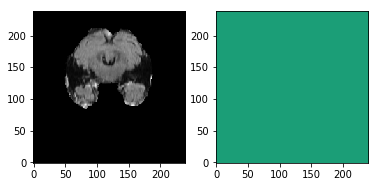

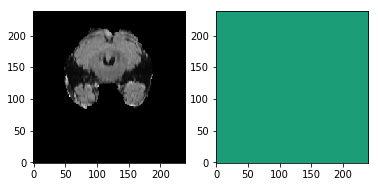

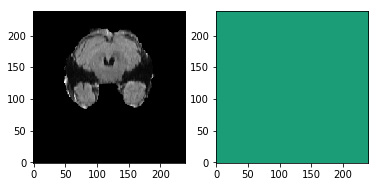

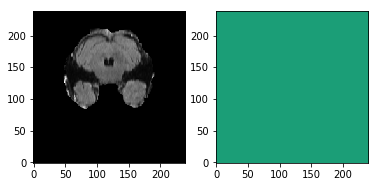

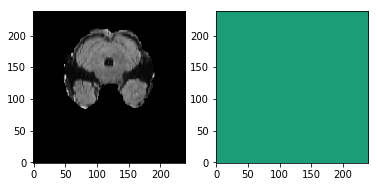

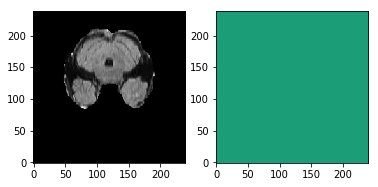

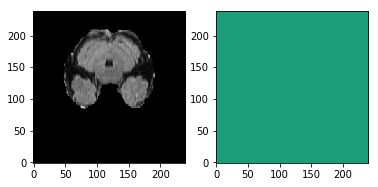

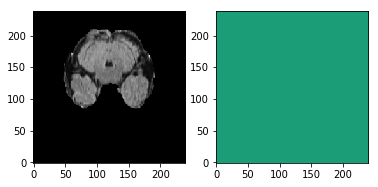

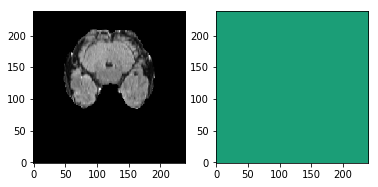

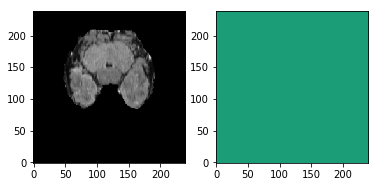

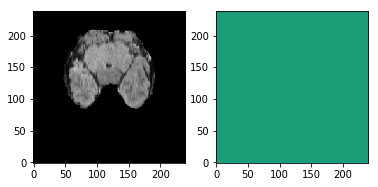

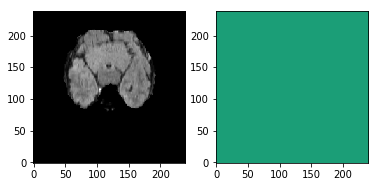

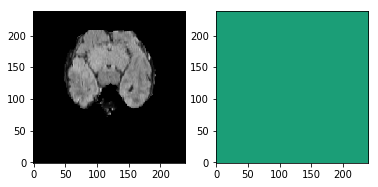

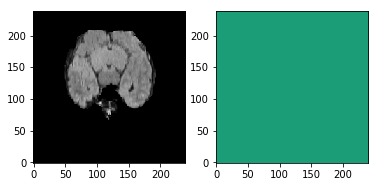

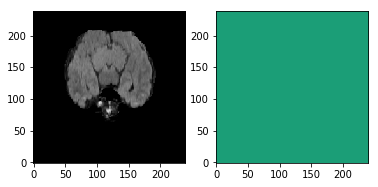

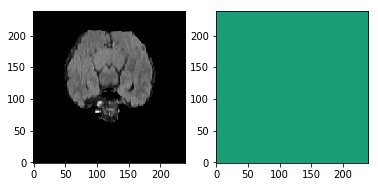

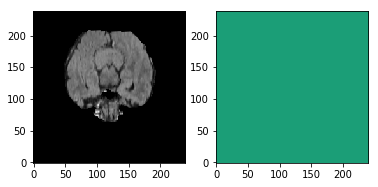

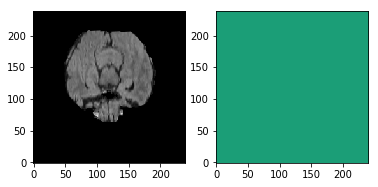

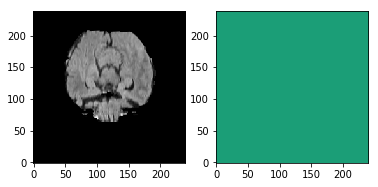

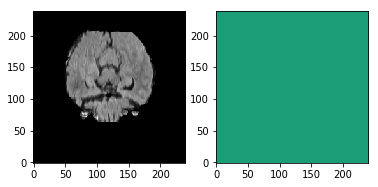

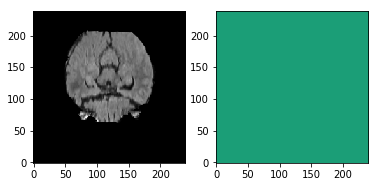

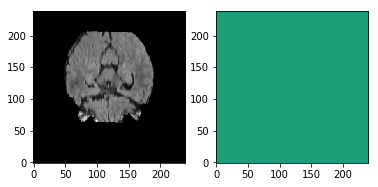

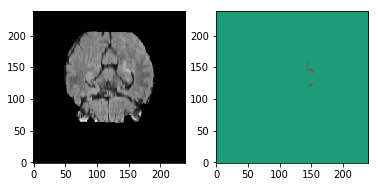

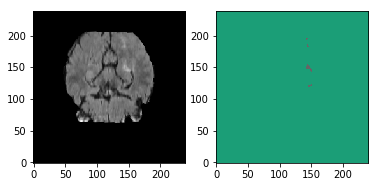

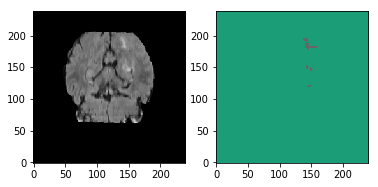

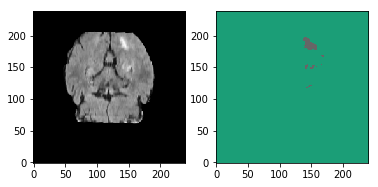

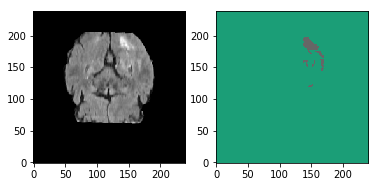

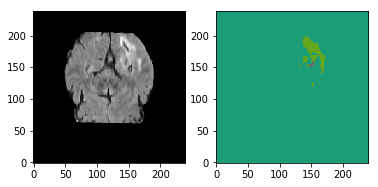

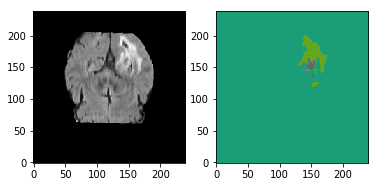

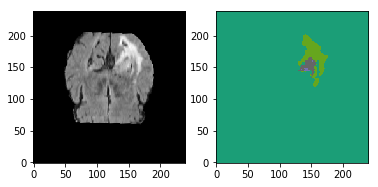

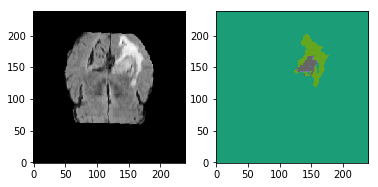

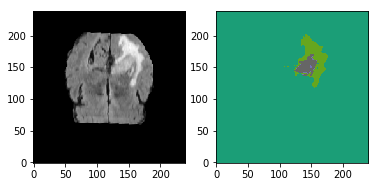

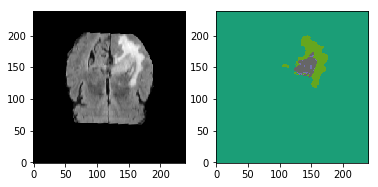

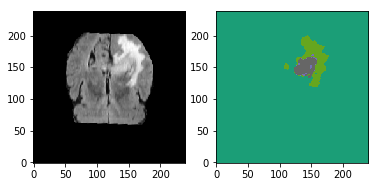

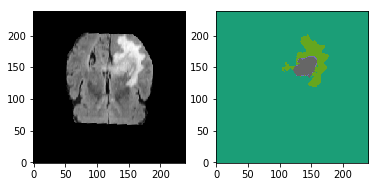

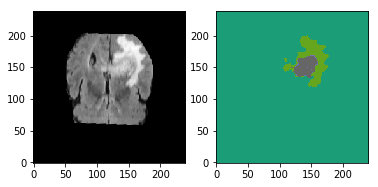

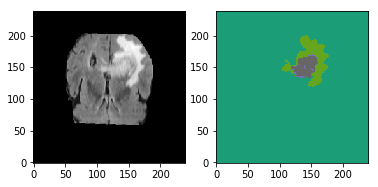

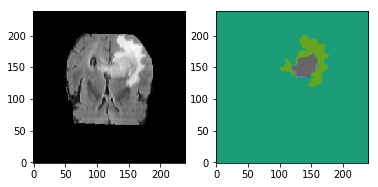

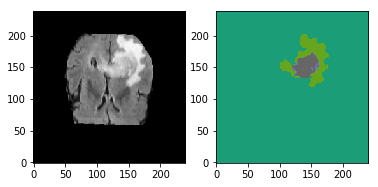

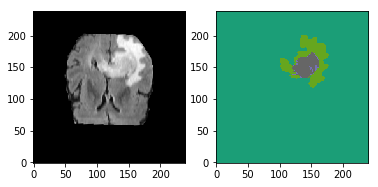

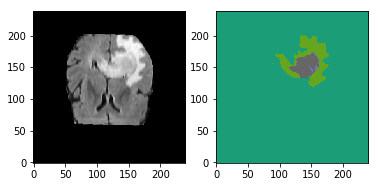

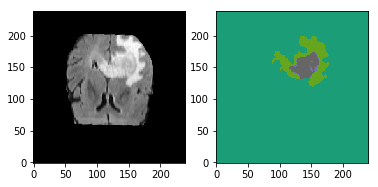

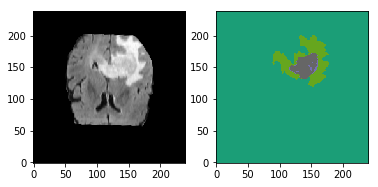

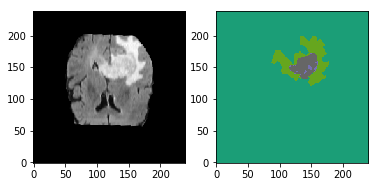

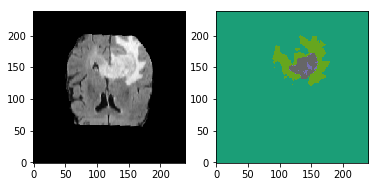

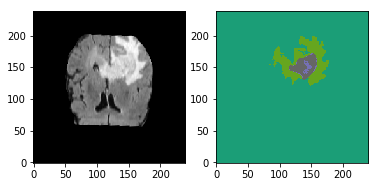

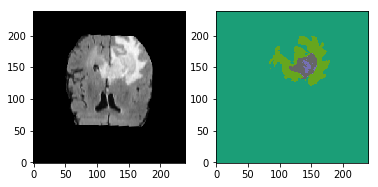

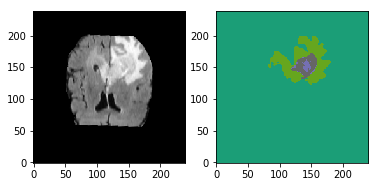

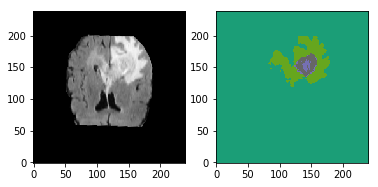

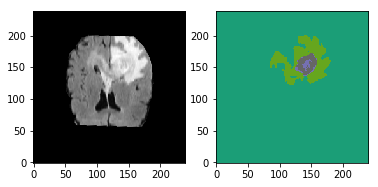

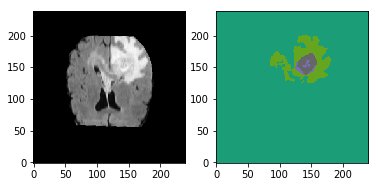

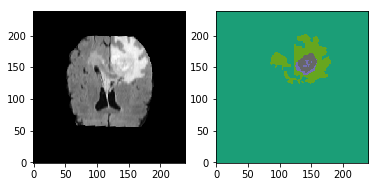

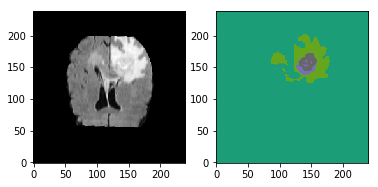

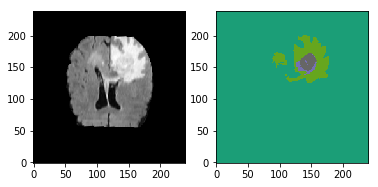

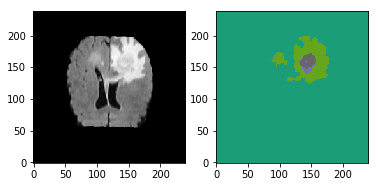

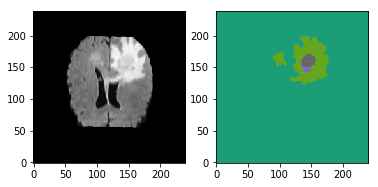

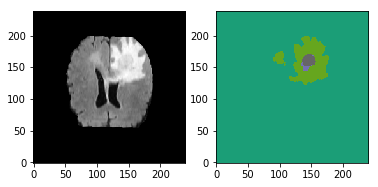

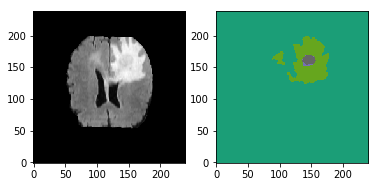

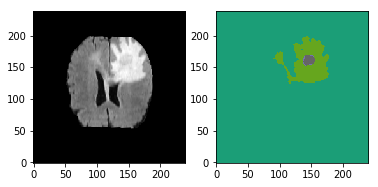

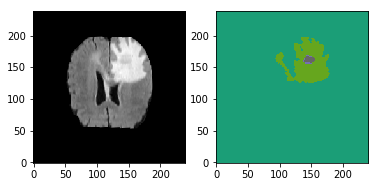

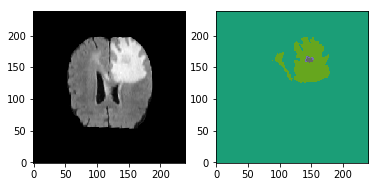

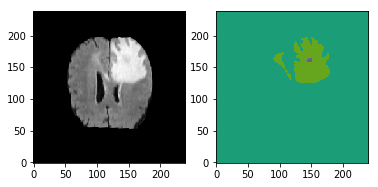

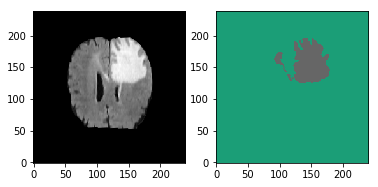

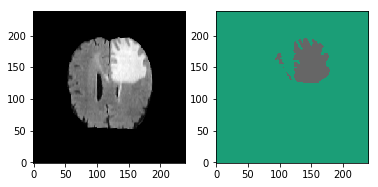

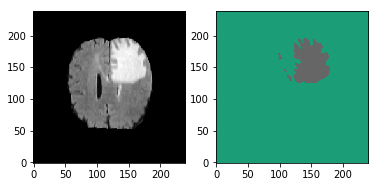

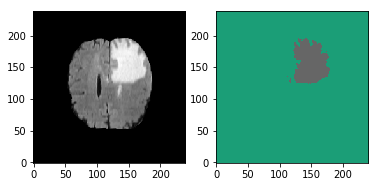

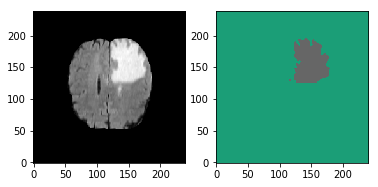

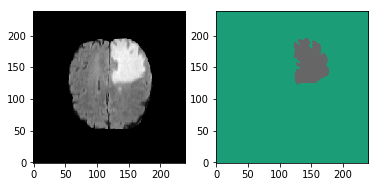

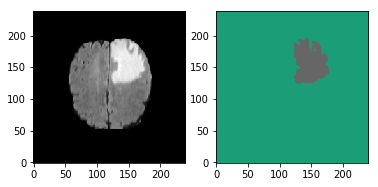

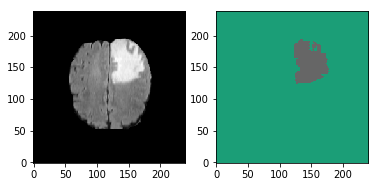

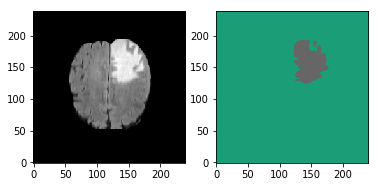

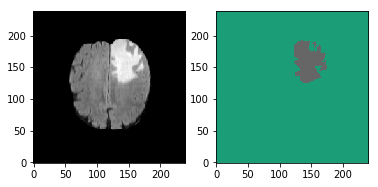

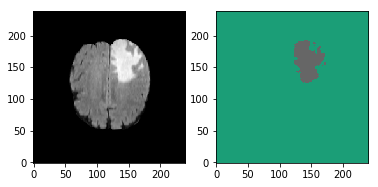

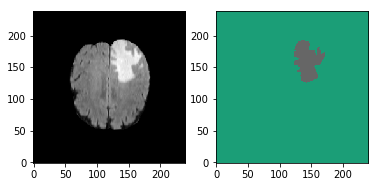

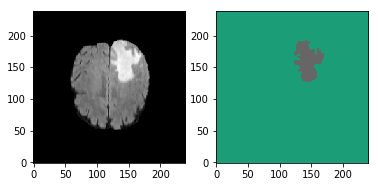

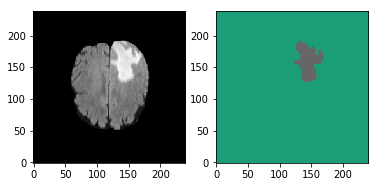

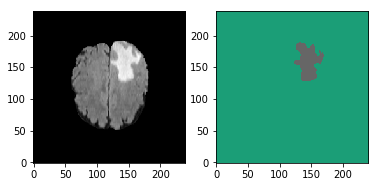

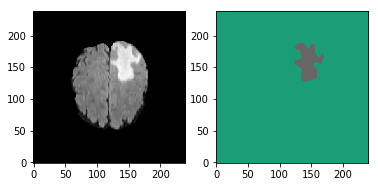

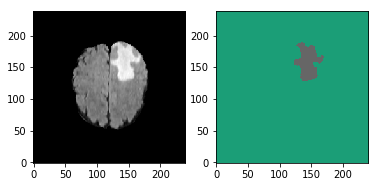

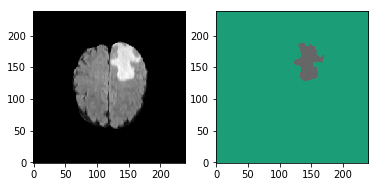

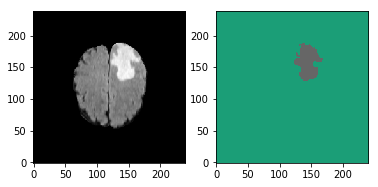

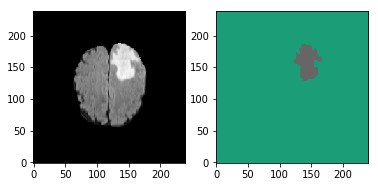

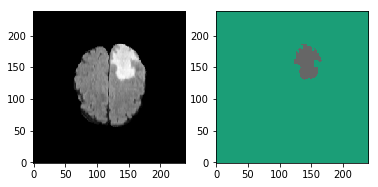

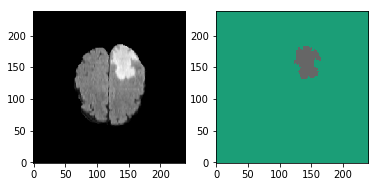

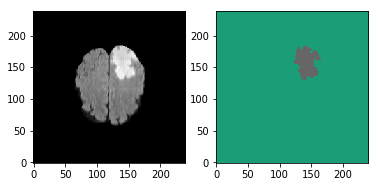

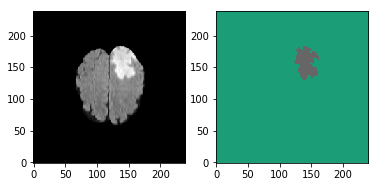

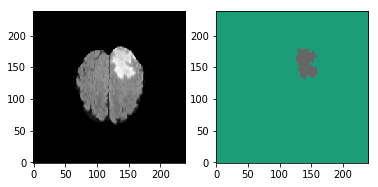

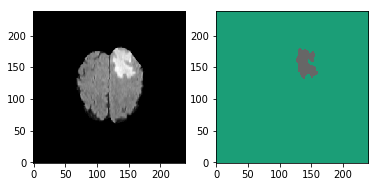

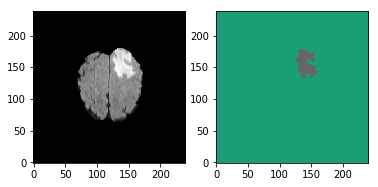

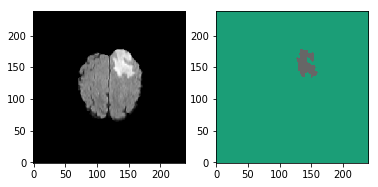

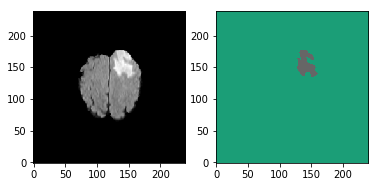

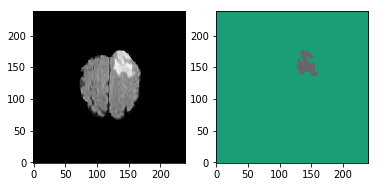

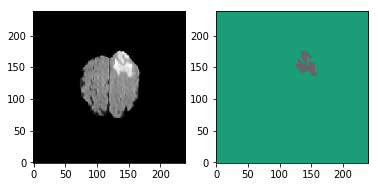

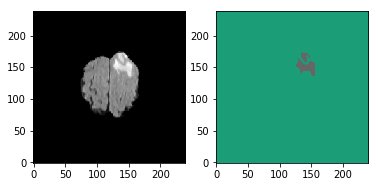

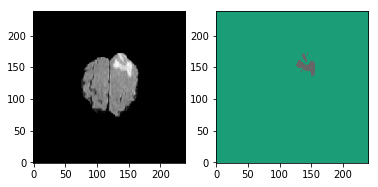

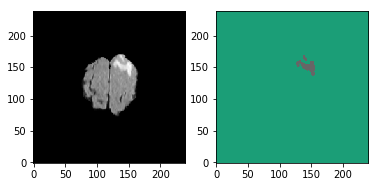

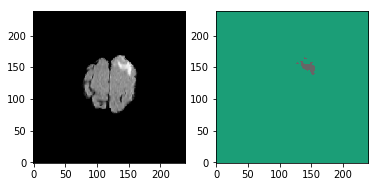

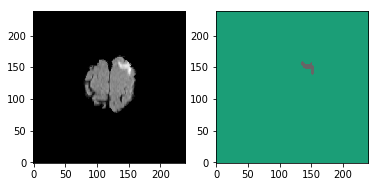

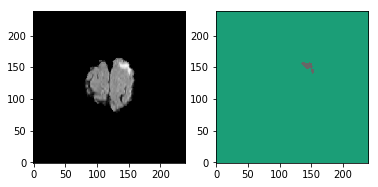

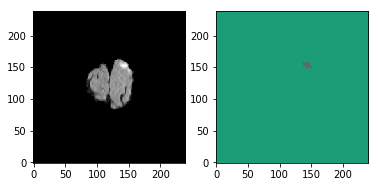

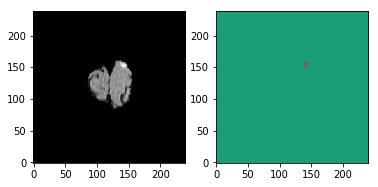

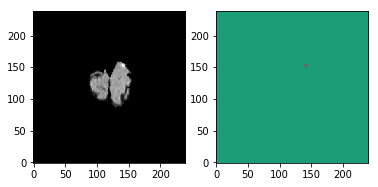

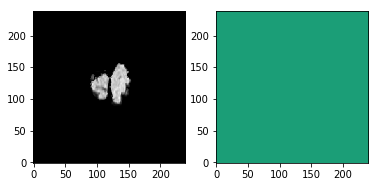

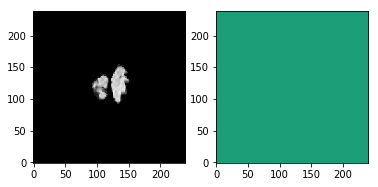

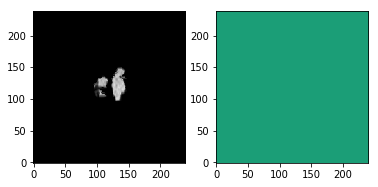

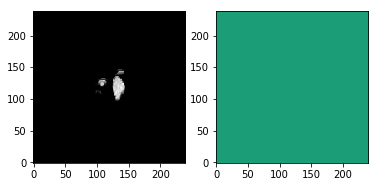

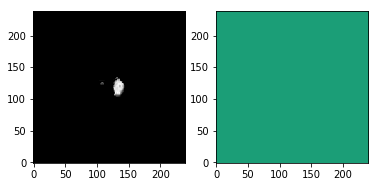

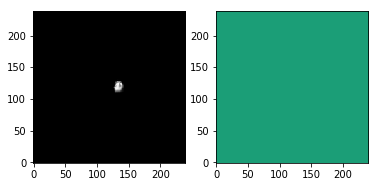

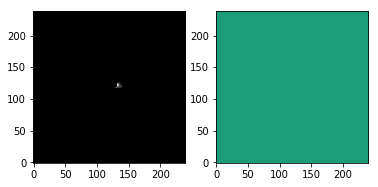

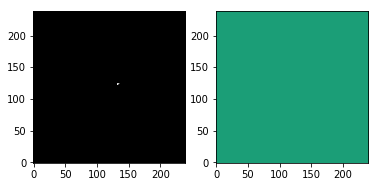

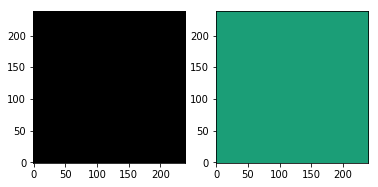

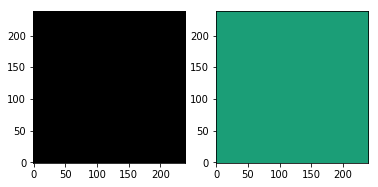

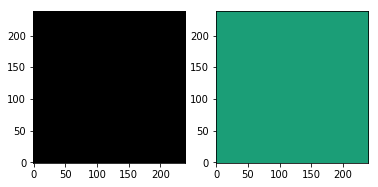

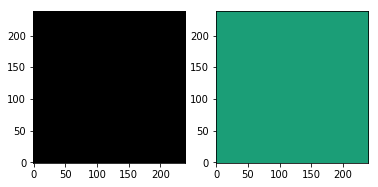

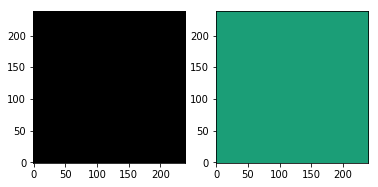

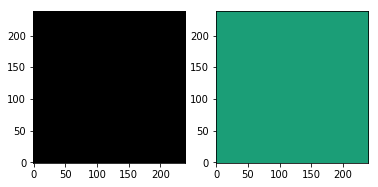

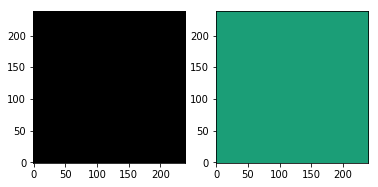

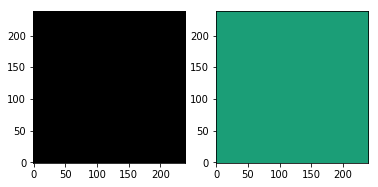

In [12]:
input_label = 'Brats17_2013_18_1_seg.nii.gz'

loaded_label = nib.load(input_label)
label_array = loaded_label.get_data()

for axial_slice_num in range(total_axial_slices):

    plt.subplot(1, 2, 1)
    im = plt.imshow(np.rot90(scan_array[:, :, axial_slice_num], 3), interpolation='none', origin='lower', cmap='gray')

    plt.subplot(1, 2, 2)
    im = plt.imshow(np.rot90(label_array[:, :, axial_slice_num], 3), interpolation='none', origin='lower', cmap='Dark2')
    
    plt.show()

Pretty cool! You can tell the label overlaps with the tumor. So far, we've just been looking at one sequence, however. Let's try and load up all of the sequences we have for this patient, and maybe do it a bit more a systematic way that we've been working on so far. This will help for later in the tutorial.

In [ ]:
import os

data_directory = '.'

def load_all_sequences_from_patients(input_directory, patient_id):

    output_arrays = []
    sequences = ['t1ce', 't1', 'flair', 't2', 'seg']
    
    for sequence in sequences:
        target_file = os.path.join(input_directory, patient_id + '_' + sequence + '.nii.gz')
        print(target_file)
        data_array = nib.load(target_file).get_data()
        output_arrays.append(data_array)
        
        # Alternate Ways to write append
        # output_arrays += [data_array]
        # output_arrays = output_arrays + [data_array]
        
    return output_arrays

T1POST, T1PRE, FLAIR, T2, GROUND_TRUTH = load_all_sequences_from_patients(data_directory, 'Brats17_2013_18_1')
    

Nice! Let's look at them again using matplotlib.

In [ ]:
input_label = ''

for axial_slice_num in range(total_axial_slices):

    for scan_number, scan in enumerate([T1POST, T1PRE, FLAIR, T2, GROUND_TRUTH]):
    
        plt.subplot(1, 5, scan_number + 1)
        im = plt.imshow(np.rot90(scan[:, :, axial_slice_num], 3), interpolation='none', origin='lower', cmap='gray')

    plt.show()

Now the goal becomes clear. Given the four images on the left, we want to produce the tumor segmentation on the right. We'll do that eventually, but for now we'll start with an easier goal. Given a slice of an brain MRI image, can we say whether or not there's a tumor in it. To do that, we'll need to start preprocessing our image. Here's how we'll do that:

- Combine our four input images into a single array with four channels
- Assess each tumor label slice, and create a ground-truth array of either tumor or no-tumor.
- Normalize the intensities in our MRI scans to have "zero mean and unit variance"